In [1]:
import arviz as az
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse
from sklearn.preprocessing import StandardScaler

import causalpy as cp
from causalpy.pymc_experiments import InstrumentalVariable
from causalpy.pymc_models import InstrumentalVariableRegression

In [2]:
%config InlineBackend.figure_format = 'retina'
seed = 42
np.random.seed(seed)

In [3]:
## Uncomment below line to local install Numpyro. 
### !conda install numpyro

## Instrumental Regression and Justifying Instruments

In this demonstration we will look into the infamous econometric question of returns to schooling. Importantly we'll see that the factors which determine success in schooling and subsequent employment are diverse and determined by social demographics and ability. Consequently there are legitimate concerns about how the effects schooling cannot be cleanly assessed without trying to account for the confounding relationships between ability and schooling. The suggestion from the econometric literature is to leverage instrumental variable regression to decompose the effect of schooling and future wage acquisition. 

In particular the suggestion is that we can use an individual's (assumed as-if random) proximity to a 4-year college as an instrument. Recall that this instrument `nearcollege` has to be: (i) __relevent__ that it effects the causal path of interest interest i.e. nearness to a college is assumed to have a causal impact on an individual's `education`, (ii) __independent__ assignment to instrument be as good as randomly assigned to mitigate the original selection effect bias and (iii) meets the __exclusion restriction__ the instrument should influence the outcome `wage` only through the treatment of interest `education`. If these conditions are met then, we can argue that the instrumental variable regression techniques can distil the causal impact of our treatment. 

In many ways instrumental variable regression is a paradigmatic method of the credibility revolution in econometrics and the social sciences. As such we will elaborate how to explore the assumptions of the design and highlight the conditions under which it can be sensibly applied. 

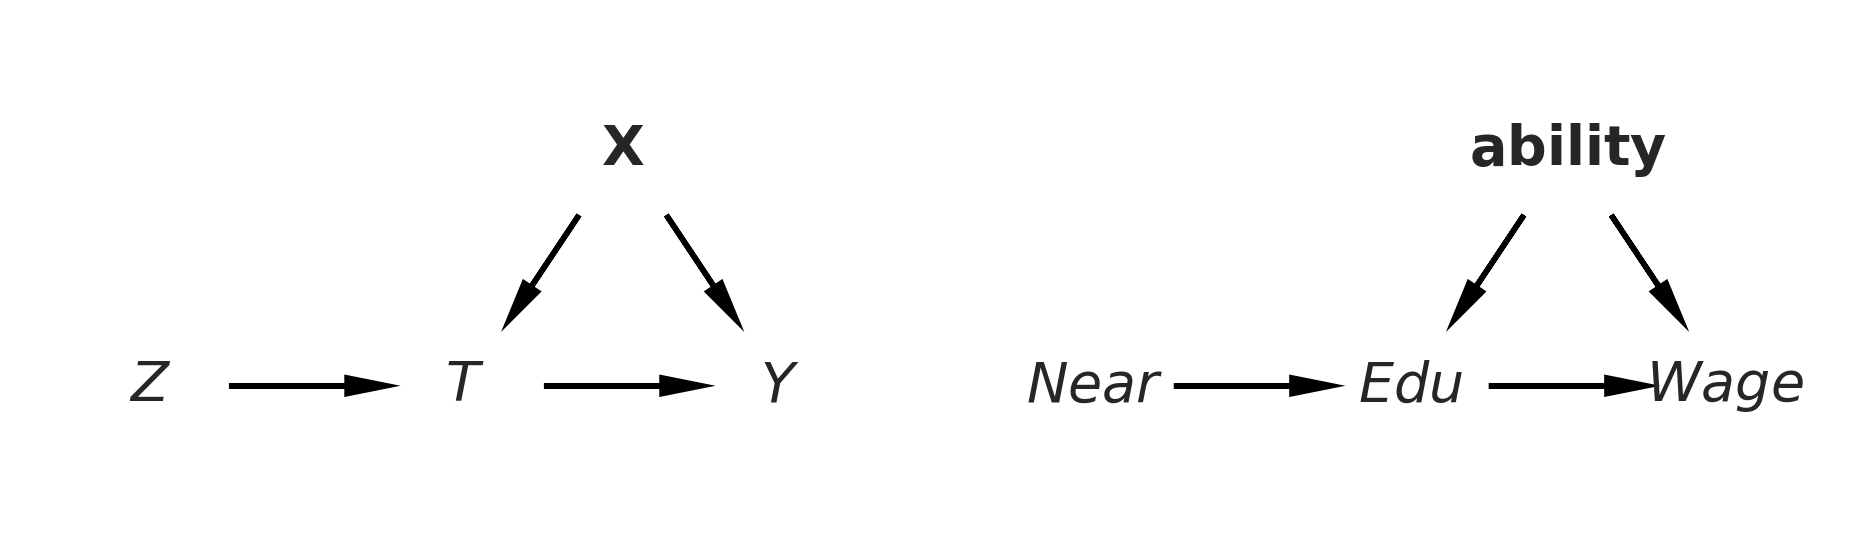

In [46]:
GRID_UNIT = 2.0
DPI = 200
NODE_EC = "none"

pgm = daft.PGM(dpi=DPI, grid_unit=GRID_UNIT, node_ec=NODE_EC)

pgm.add_node("z", "$Z$", 0, 0)
pgm.add_node("t", "$T$", 1, 0)
pgm.add_node("y", "$Y$", 2, 0)
pgm.add_node("x", "$\mathbf{X}$", 1.5, 0.75)
pgm.add_edge("z", "t")
pgm.add_edge("x", "t")
pgm.add_edge("x", "y")
pgm.add_edge("t", "y")


pgm.add_node("nearcollege", "$Near$", 3, 0)
pgm.add_node("education", "$Edu$", 4, 0)
pgm.add_node("wage", "$Wage$", 5, 0)
pgm.add_node("ability", "$\mathbf{ability}$", 4.5, 0.75)
pgm.add_edge("nearcollege", "education")
pgm.add_edge("ability", "education")
pgm.add_edge("ability", "wage")
pgm.add_edge("education", "wage")

pgm.render();

### Regression Mechanics and (L)ocal(A)verage(T)reatment(E)ffect

The structure of an instrumental variable problem helps us get at the question of causal impact, but it does not target the typical ATE causal estimand. Instead we must be happy to estimate the LATE quantity. Where we evaluate a restricted treatment effect among the "compliers" in our design. This makes sense because implicitly evaluating the effect of a treatment in a population where there is no guarantee of compliance. So we can't make the more general claim to have assessed change on average. It is rather an evaluation of change in the sub-population that have been induced to comply with our design. Those individuals for whom the treatment T has been influenced by our instrument Z.

The theory of the LATE estimator is rich. There are multiple ways of isolating the LATE estimate. 

$$\tau = LATE= \frac{E[Y | Z = 1] - E[Y | Z = 0]}{E[T | Z = 1] - E[T | Z = 0]} = \frac{\phi}{\psi} = \frac{\text{reduced form}}{\text{first stage}} $$

The last phrasing there is highlights the fact that we're interested in two components of variation due to our instrument $Z$. This is one way of seeing that we're trying to estimate a __joint distribution__ of two random variables in a structural equation model. But more importantly we're assuming via __relevance__ that there is some non-trivial correlation between the realisations of the instrument $Z$, the treatment $T$. All the more important then to choose instruments relevant to the sub-population of interest or where compliance is expected to be high.

### Digression: Sampling Multivariate Normals

How can we measure this correlation between instrument and treatment? How much correlation should we expect? In the `CausalPy` implementation of instrumental variable regression we model this correlation explicity using an LKJ Cholesky prior on a Multivariate Normal distribution. It's worth a small digression here to show how sampling from this distribution under different priors can shape the correlations of the joint-distribution. We'll show below how this offers us a mechanism to impose constraints on our beliefs about the relationships between our instruments. 

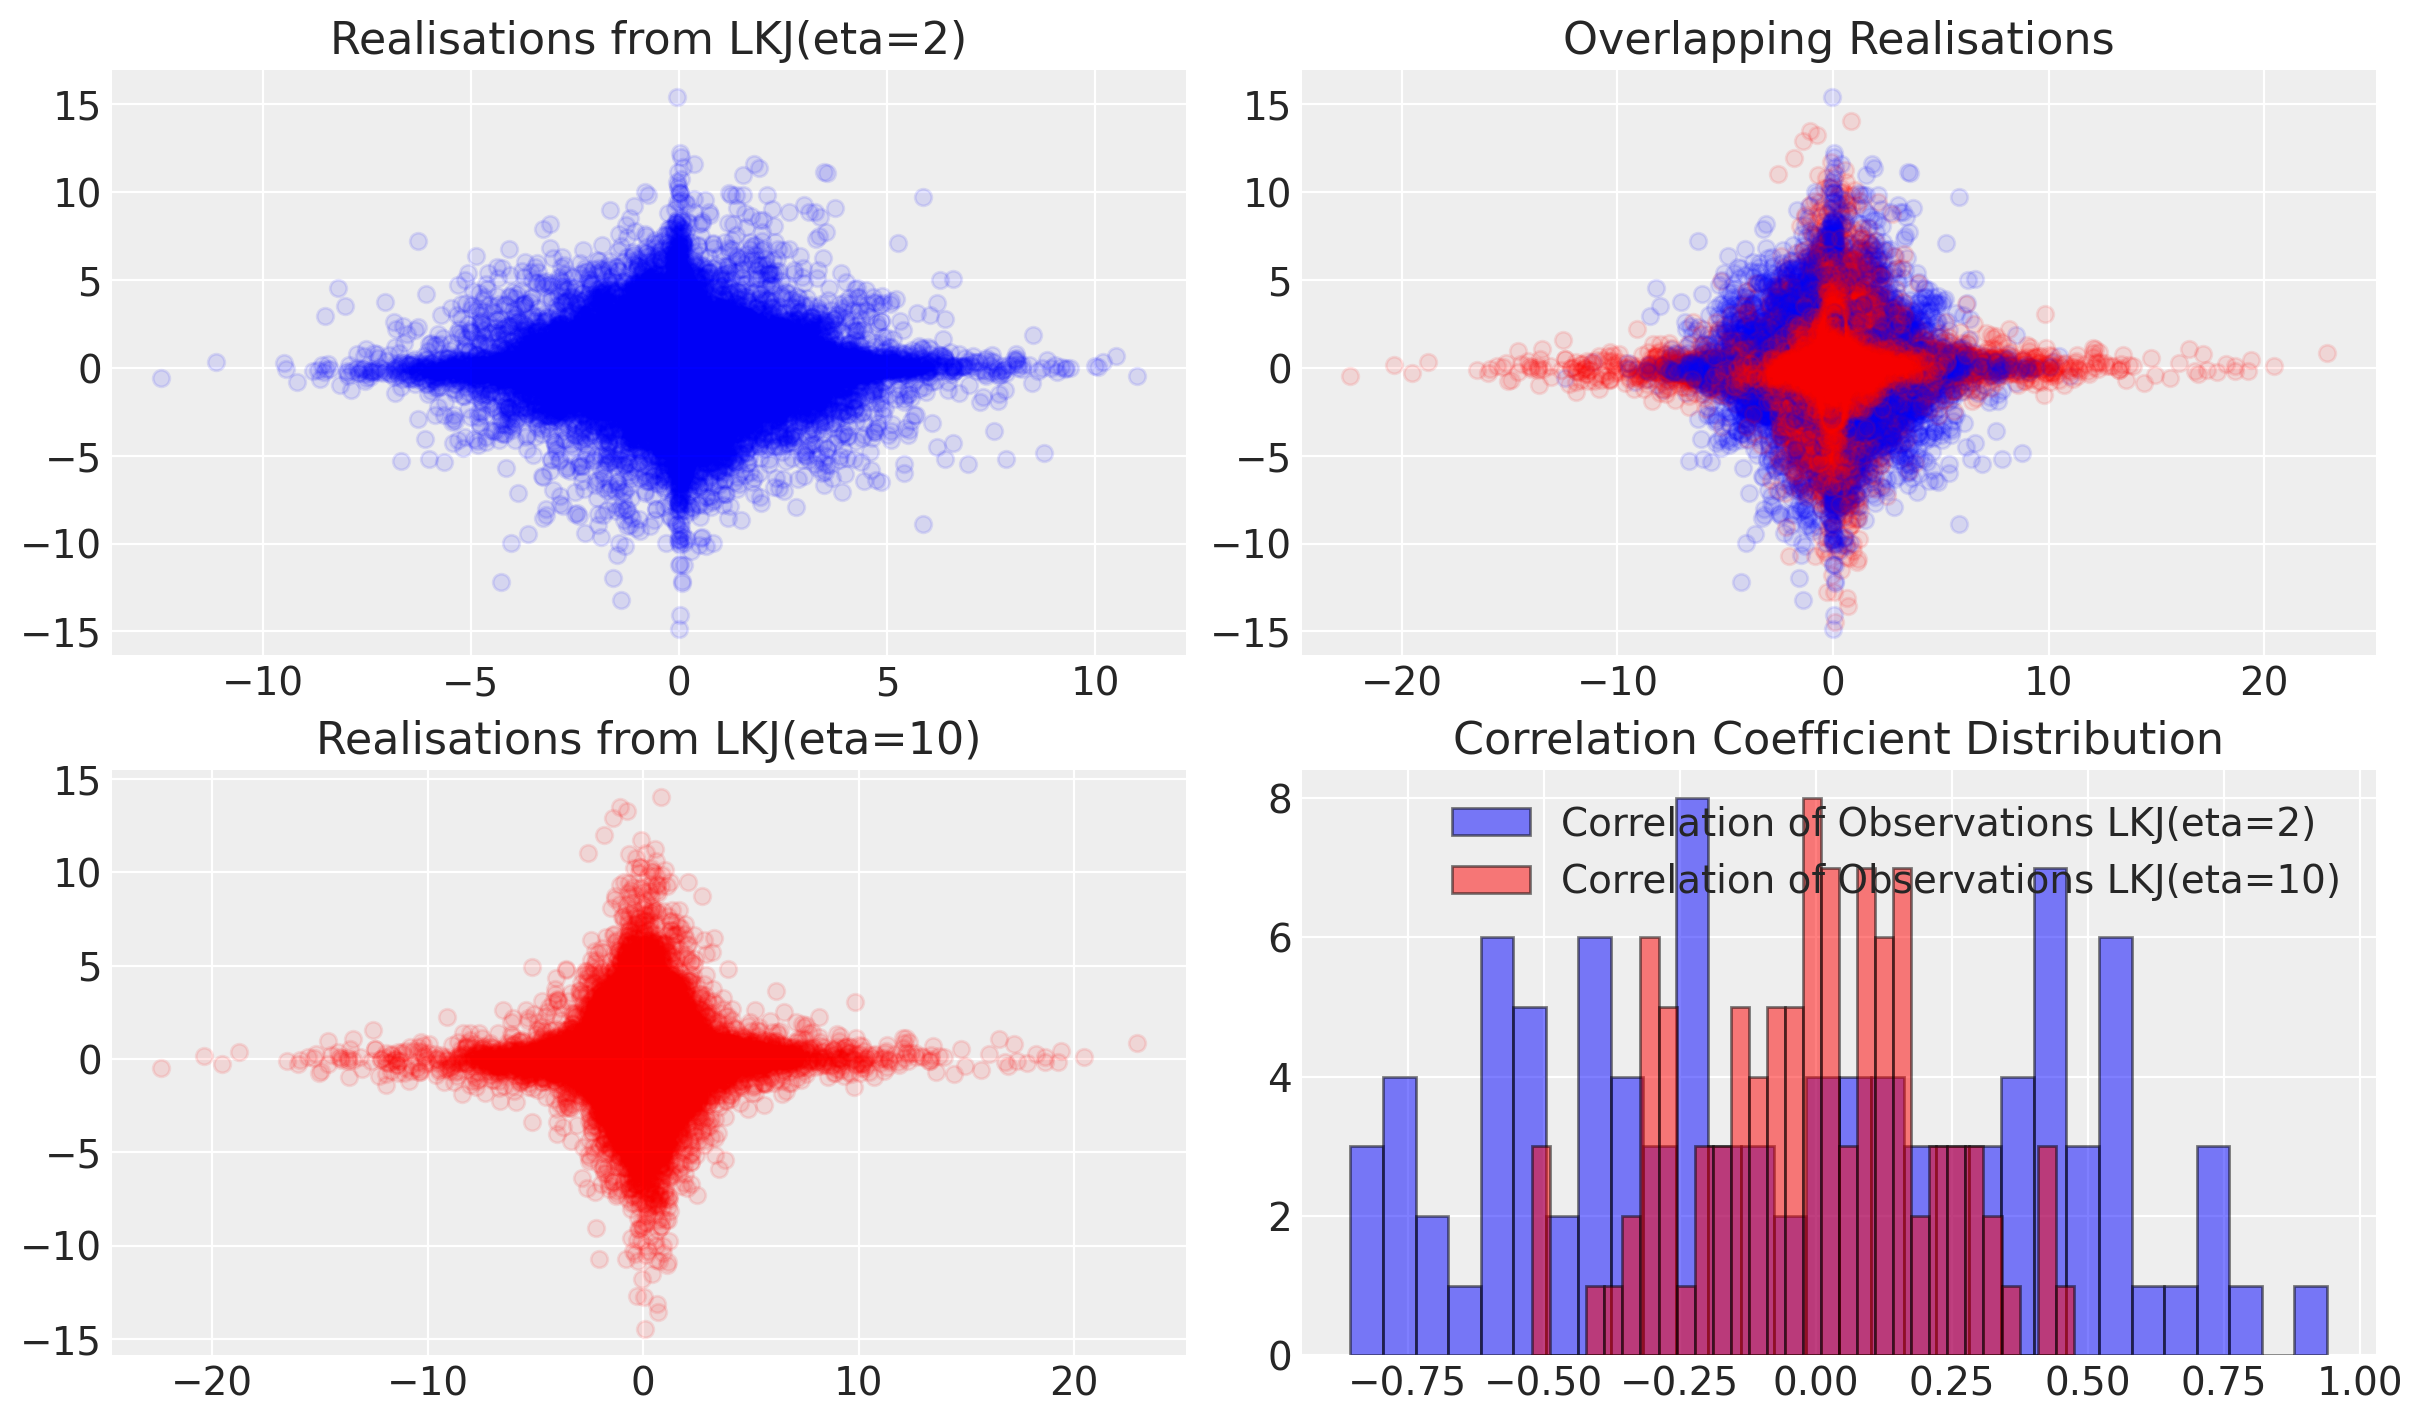

In [4]:
sd_dist = pm.Exponential.dist(1.0, shape=2)
lkj = pm.LKJCholeskyCov.dist(
                    eta=2,
                    n=2,
                    sd_dist=sd_dist,
        )
lkj1 = pm.LKJCholeskyCov.dist(
                    eta=10,
                    n=2,
                    sd_dist=sd_dist,
        )
chol, corr, sigmas = pm.draw(lkj, draws=100)
chol1, corr1, sigmas = pm.draw(lkj1, draws=100)

fig, axs = plt.subplots(2, 2, figsize=(12, 7))
axs = axs.flatten()
corrs = []
corrs1 = []
for i in range(100):
        xy = pm.draw(pm.MvNormal.dist(0, chol=chol[i]), 1000)
        xy1 = pm.draw(pm.MvNormal.dist(0, chol=chol1[i]), 1000)
        corrs.append(np.corrcoef(xy[:, 0], xy[:, 1])[0][1])
        corrs1.append(np.corrcoef(xy1[:, 0], xy1[:, 1])[0][1])

        axs[0].scatter(xy[:, 0], xy[:, 1], alpha=0.1, color='blue')
        axs[2].scatter(xy1[:, 0], xy1[:, 1], alpha=0.1, color='red')
        axs[1].scatter(xy[:, 0], xy[:, 1], alpha=0.1, color='blue')
        axs[1].scatter(xy1[:, 0], xy1[:, 1], alpha=0.1, color='red')
axs[3].hist(np.array(corrs), bins=30, 
            ec='black', label='Correlation of Observations LKJ(eta=2)', color='blue', alpha=0.5)
axs[3].hist(np.array(corrs1), bins=30, 
            ec='black', label='Correlation of Observations LKJ(eta=10)', color='red', alpha=0.5)
axs[3].legend()
axs[3].set_title("Correlation Coefficient Distribution")
axs[0].set_title("Realisations from LKJ(eta=2)")
axs[1].set_title("Overlapping Realisations")
axs[2].set_title("Realisations from LKJ(eta=10)");

Here we can see that increasing the `eta` parameter on the LKJ prior shrinks the range of admissable correlations parameters. By default the `CausalPy` implementation sets the `eta=2`. This is worth knowing if your model makes such potential correlations very unlikely. We will show below how you can apply priors to these parameters in the instrumental variable context. 

### The Data: Returns to Schooling

We use a data set from the U.S. National Longitudinal Survey of Young Men (NLSYM) in 1976. This data was sourced from the R `ivreg` package. Originally the data is used to replicate some of the famous work from Card's 1995 paper _Using Geographical Variation in College Proximity to Estimate the Return to Schooling_ in which he aimed to distil the causal impact of education on wages. {cite:t}`card1995returns`

In [5]:
df = cp.load_data("schoolReturns")


def poly(x, p): #replicate R's poly decompostion function
    X = np.transpose(np.vstack([x**k for k in range(p+1)]))
    return np.linalg.qr(X)[0][:,1:]


df['log_wage'] = np.log(df['wage'])
df[['experience_1', 'experience_2']] = pd.DataFrame(poly(df['experience'].values, 2))
df[['age_1', 'age_2']] = poly(df['age'].values, 2)
df['nearcollege_indicator'] = np.where(df['nearcollege'] == 'yes', 1, 0) # 4 year college
df['nearcollege2_indicator'] = np.where(df['nearcollege2'] == 'yes', 1, 0) # 2 year college
df['nearcollege4_indicator'] = np.where(df['nearcollege4'] == 'yes', 1, 0) # 4 year public or private college
df['south_indicator'] = np.where(df['south'] == 'yes', 1, 0) # southern US
df['smsa_indicator'] = np.where(df['smsa'] == 'yes', 1, 0) # standard metropolitan statistical area
df['ethnicity_indicator'] = np.where(df['ethnicity'] == 'afam', 1, 0) # African-American or other
df[['wage', 'education', 'experience','ethnicity', 'nearcollege']]

wage  education  experience ethnicity nearcollege
0      548          7          16      afam          no
1      481         12           9     other          no
2      721         12          16     other          no
3      250         11          10     other         yes
4      729         12          16     other         yes
...    ...        ...         ...       ...         ...
3005   335         12           7     other         yes
3006   481         13          15     other         yes
3007   500         12           6     other         yes
3008   713         12          13     other         yes
3009   525         13           7      afam         yes

[3010 rows x 5 columns]

We can split out the flag features and just look at how the outcome varies conditional on different levels of the population strata. 

In [6]:
(df.assign(age_cut = lambda x: pd.qcut(x['age'], 4)).groupby(['nearcollege', 'smsa', 'ethnicity', 'south', 'age_cut'])[['log_wage']].mean()
 .reset_index().pivot(index=['smsa', 'ethnicity', 'south', 'age_cut'], columns='nearcollege', values='log_wage')
 .reset_index().assign(diff = lambda x: x['no'] - x['yes'])
 .sort_values('diff', ascending=False).style.background_gradient(axis=0, subset='diff')  
 )

/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_4265/3346395000.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (df.assign(age_cut = lambda x: pd.qcut(x['age'], 4)).groupby(['nearcollege', 'smsa', 'ethnicity', 'south', 'age_cut'])[['log_wage']].mean()


This should just highlight the magnitude of change we might expect in the outcome variable holding all else equal for varying the group membership. 

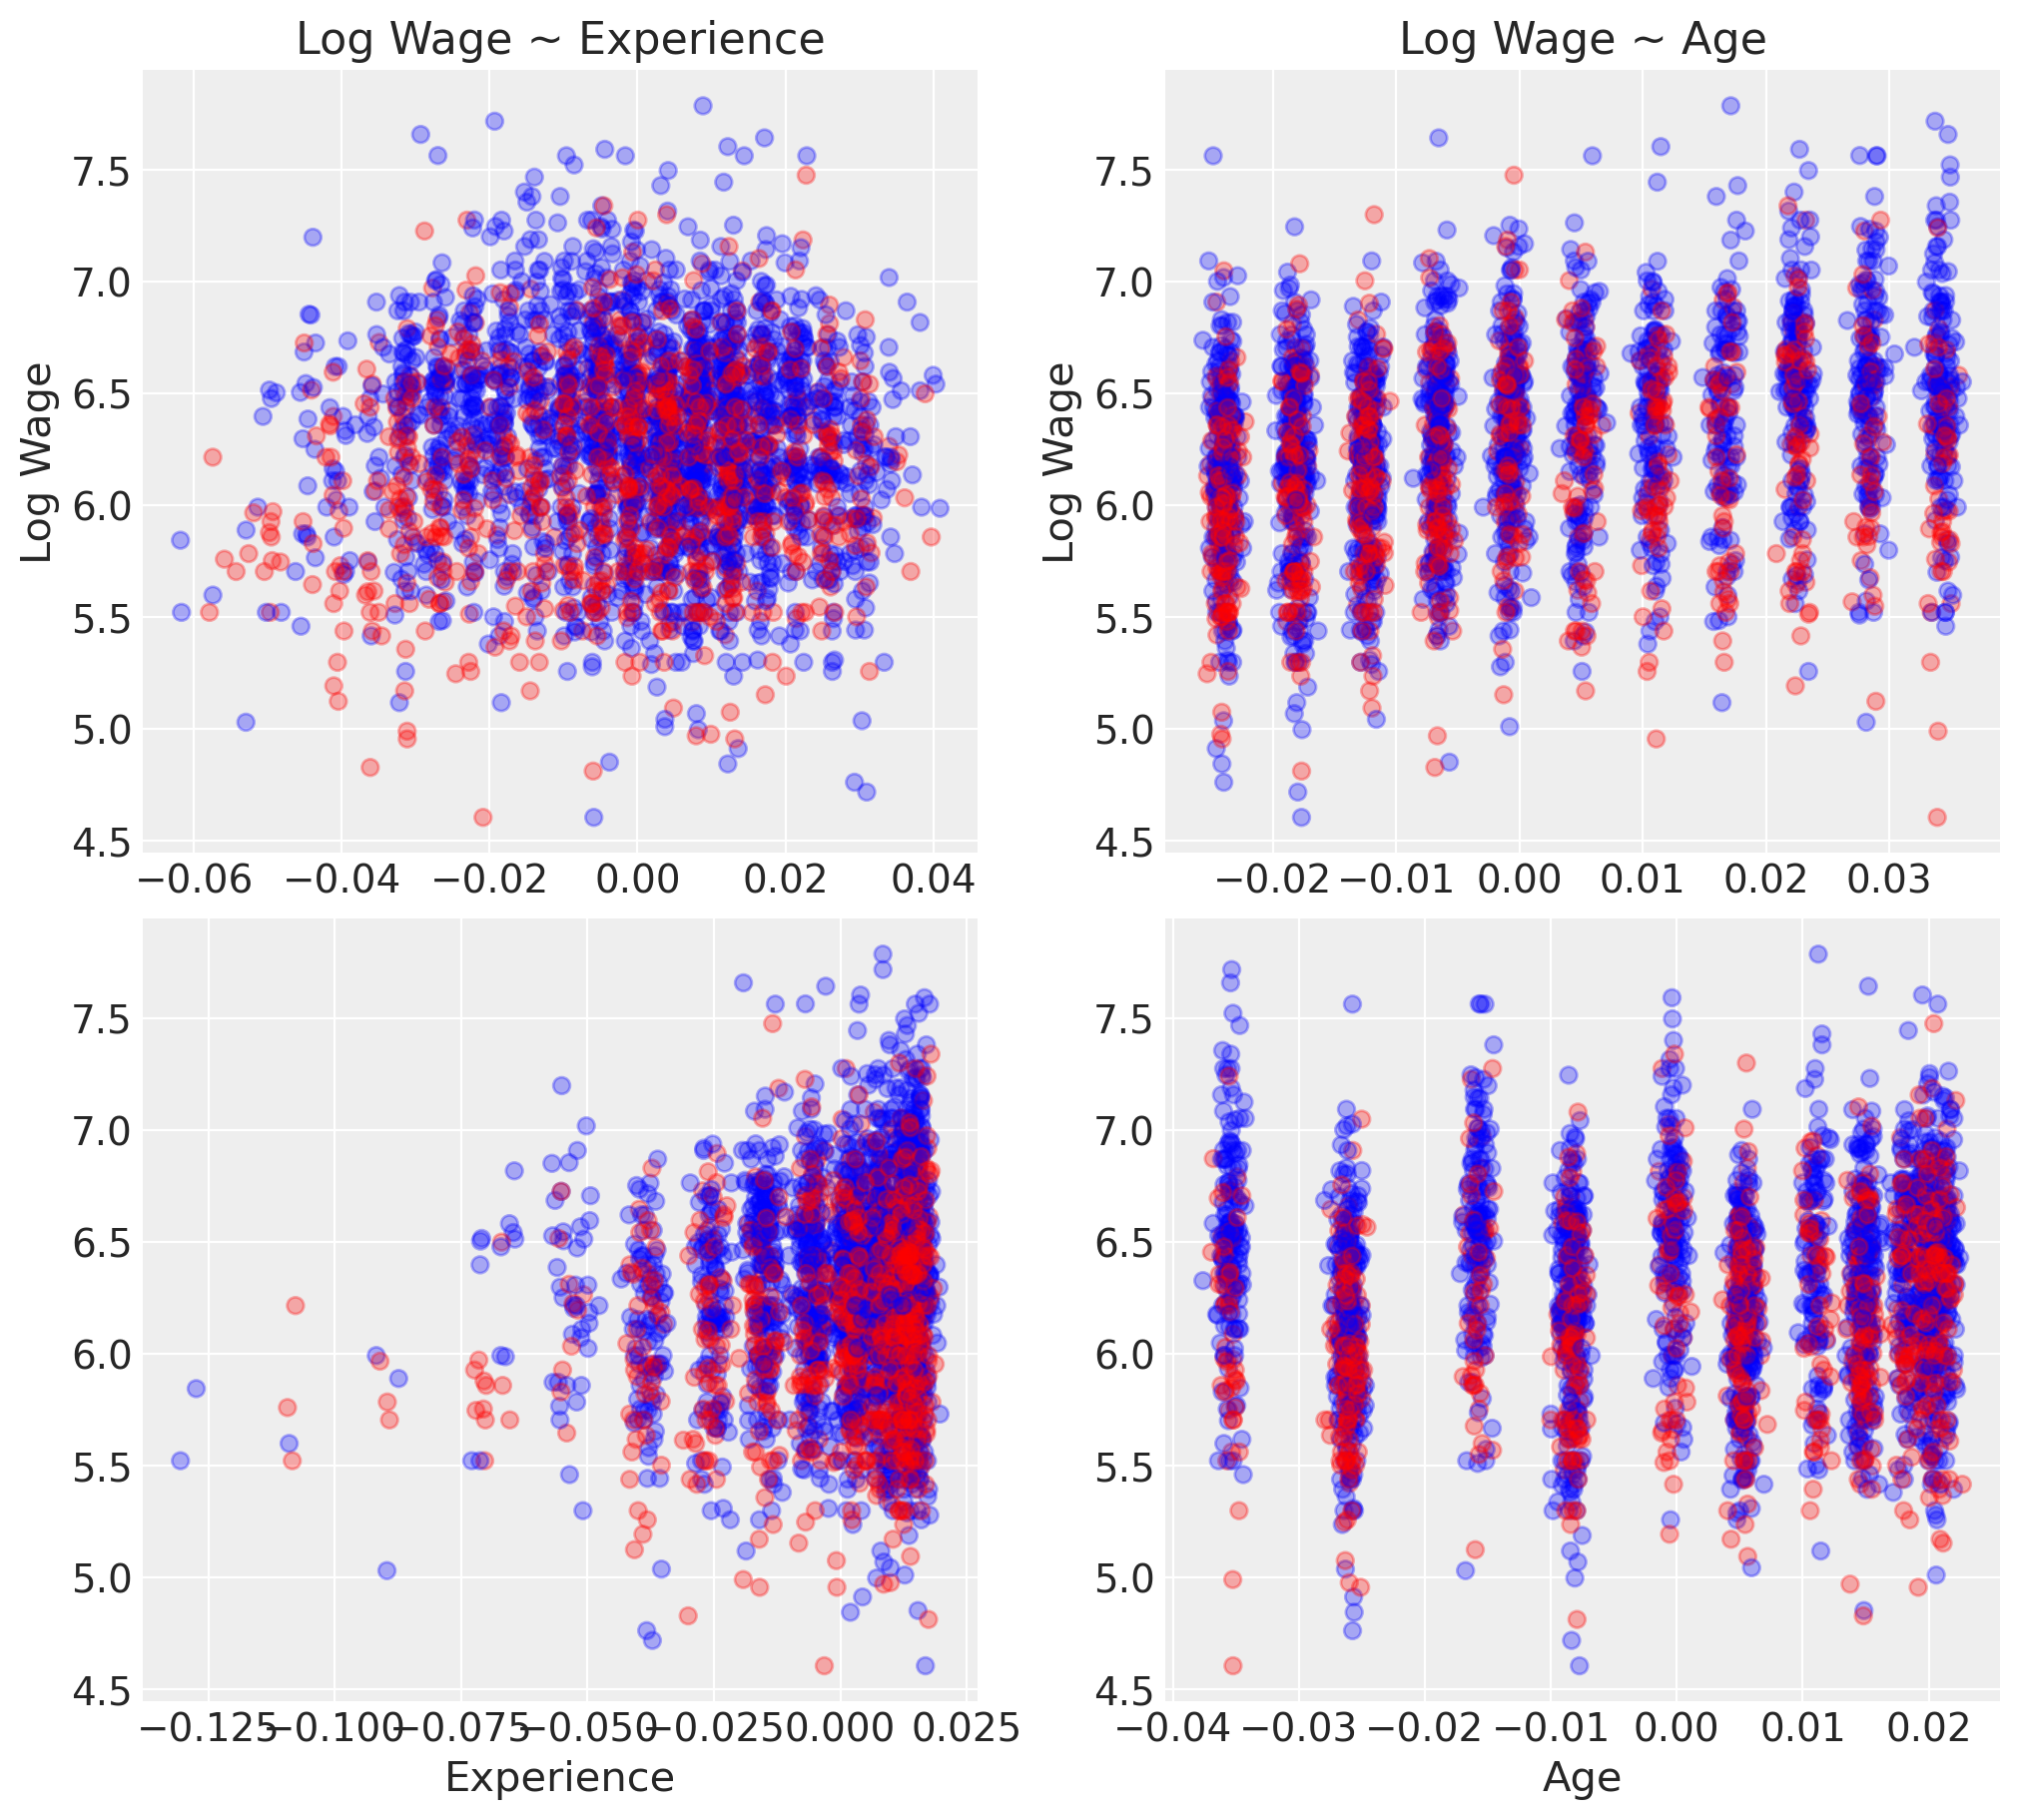

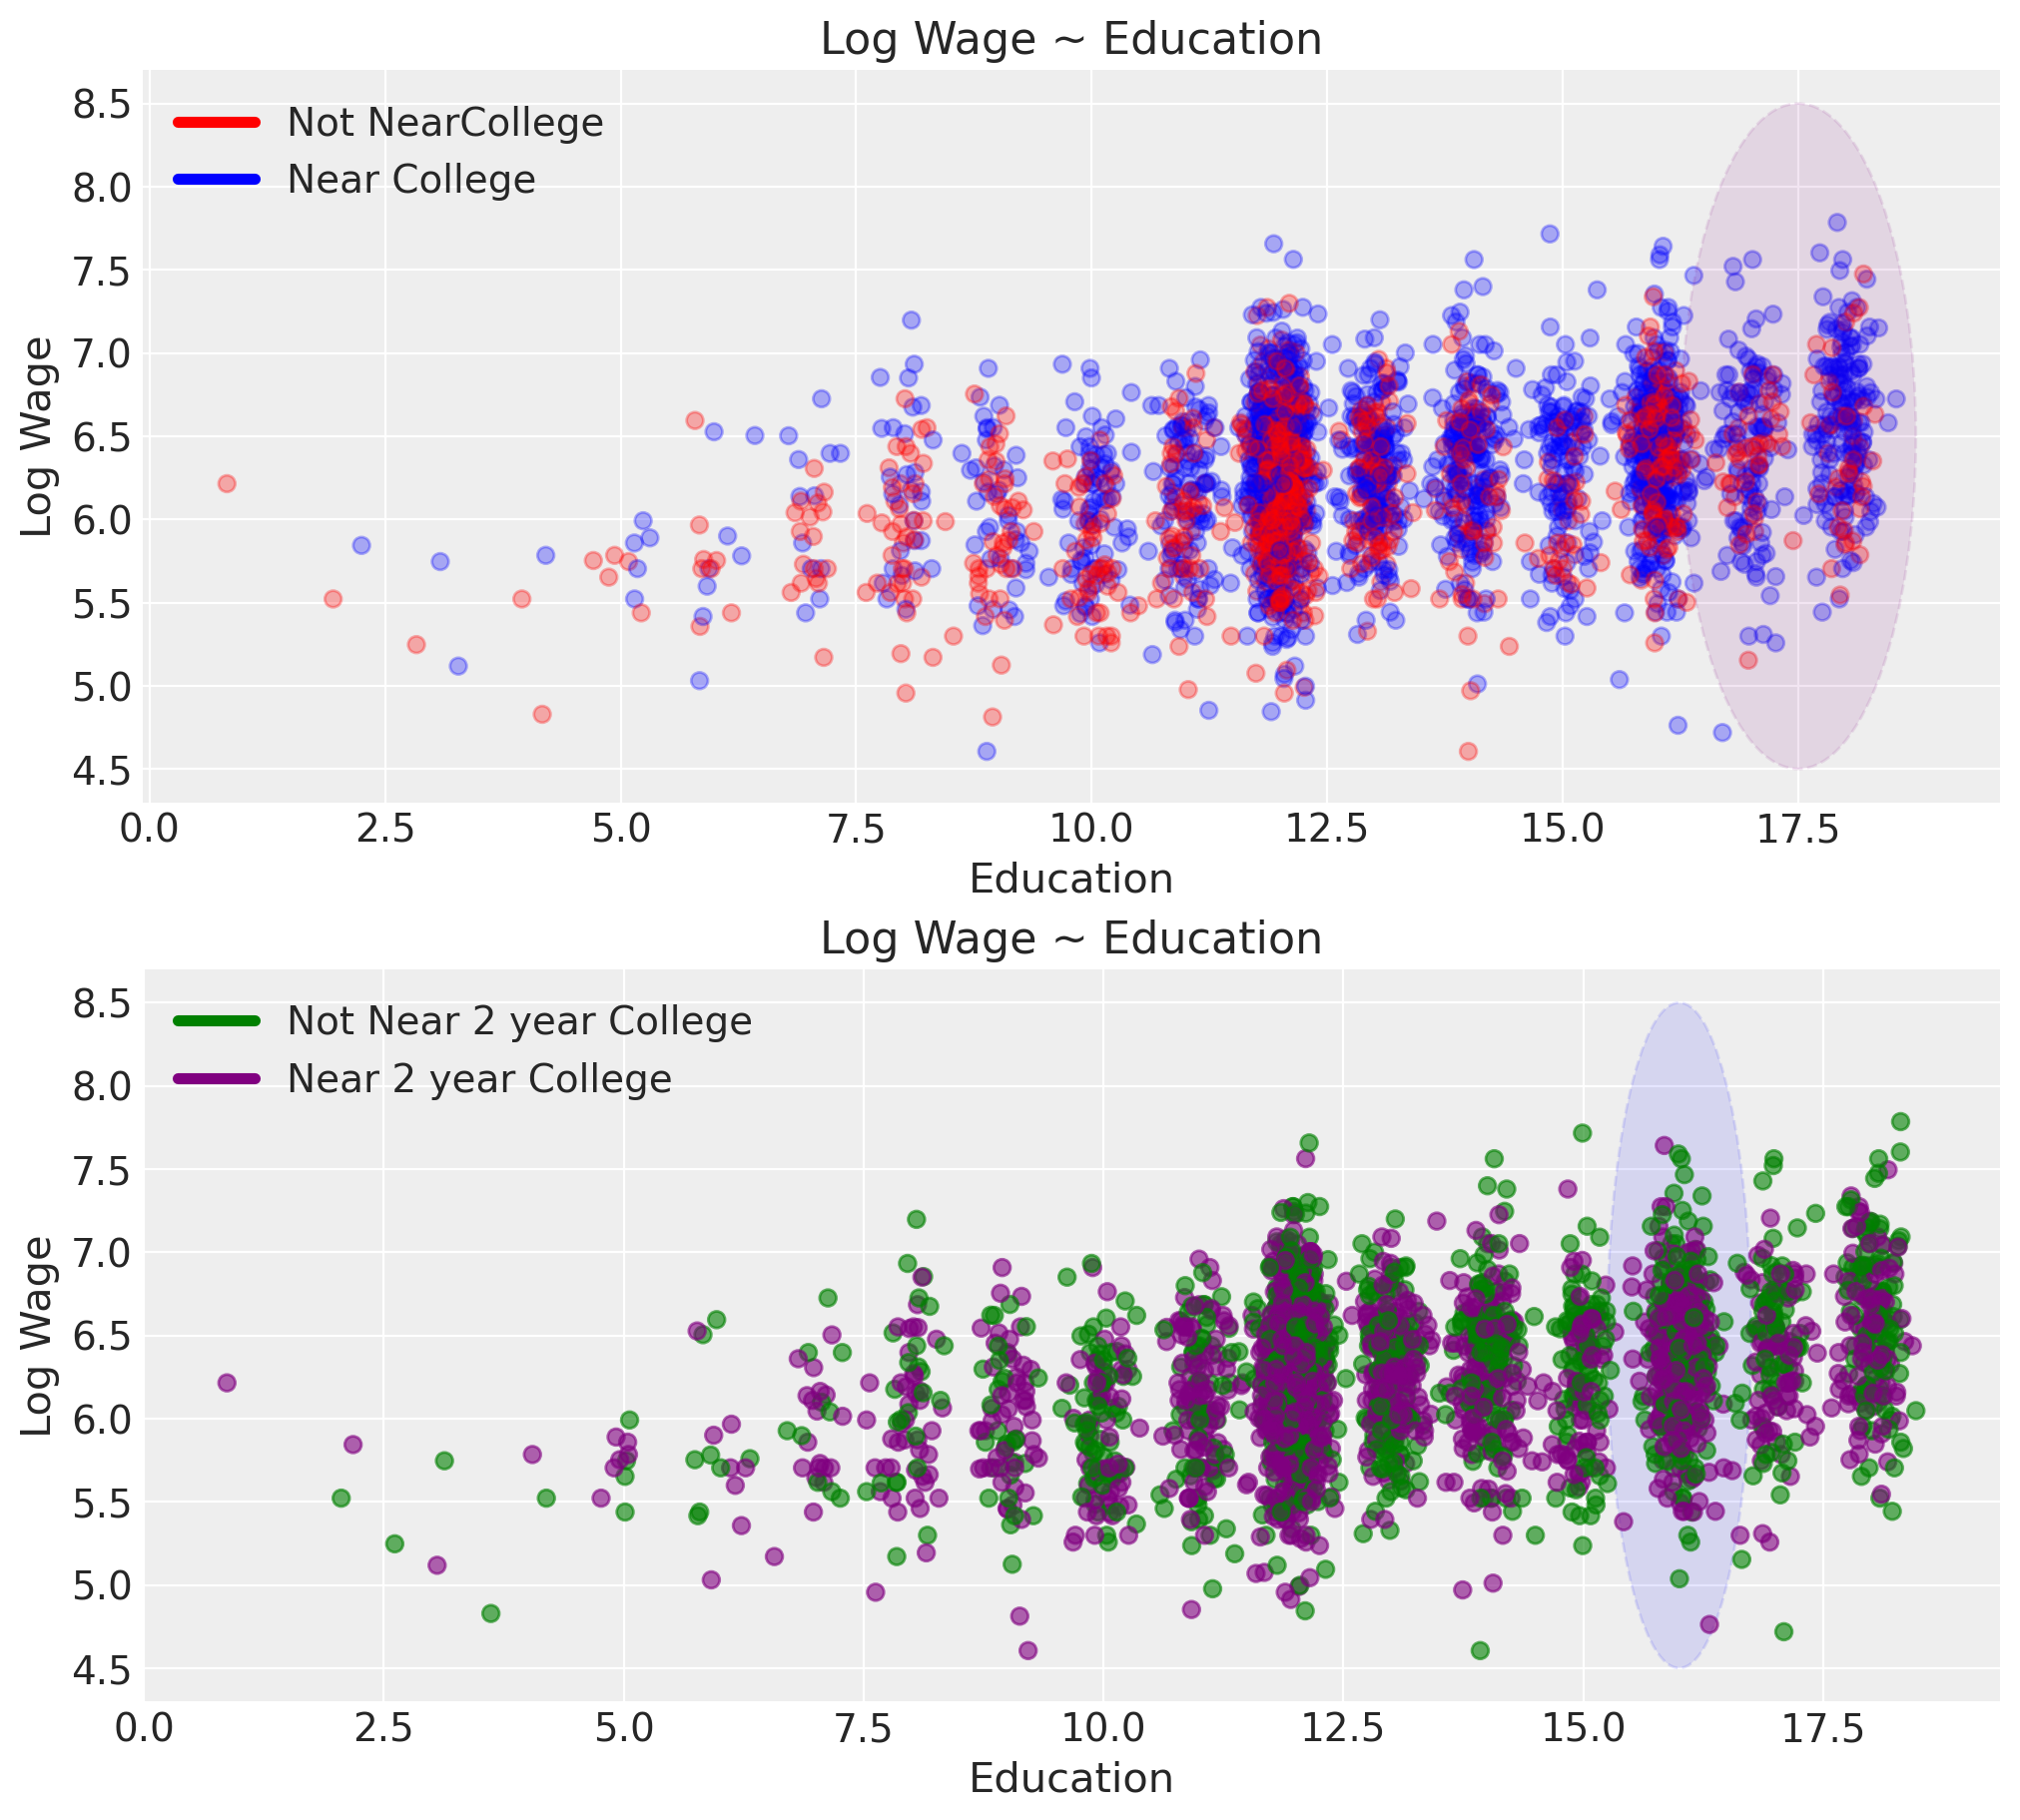

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(10, 9))


def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev


col = np.where(df.nearcollege_indicator,'b','r')
axs = axs.flatten()
axs[0].scatter(rand_jitter(df['experience_1']), df['log_wage'], c=col, alpha=0.3)
axs[2].scatter(rand_jitter(df['experience_2']), df['log_wage'], c=col, alpha=0.3)
axs[2].set_xlabel("Experience")
axs[1].scatter(rand_jitter(df['age_1']), df['log_wage'], c=col, alpha=0.3)
axs[3].scatter(rand_jitter(df['age_2']), df['log_wage'], c=col, alpha=0.3)
axs[3].set_xlabel("Age")
axs[0].set_title("Log Wage ~ Experience")
axs[1].set_title("Log Wage ~ Age")
axs[0].set_ylabel("Log Wage")
axs[1].set_ylabel("Log Wage")


custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='blue', lw=4)]


fig, axs = plt.subplots(2, 1, figsize=(10, 9))
axs  = axs.flatten()
ax = axs[0]
ax1 = axs[1]
ax.set_title("Log Wage ~ Education")
col = np.where(df.nearcollege_indicator,'b','r')
ax.scatter(rand_jitter(df['education']), df['log_wage'], c=col, alpha=0.3)
ax.legend(custom_lines, ['Not NearCollege', 'Near College'])
ax.set_xlabel("Education")
ax.set_ylabel("Log Wage")
ellipse = Ellipse((17.5, 6.5),
        width=4,
        height=2.5,
        angle=90, 
        facecolor=None, 
        alpha=0.1,
        color='purple',
        linestyle='--'
        )
ax.add_patch(ellipse)

custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='purple', lw=4)]
ax1.set_title("Log Wage ~ Education")
col = np.where(df.nearcollege2_indicator,'g','purple')
ellipse = Ellipse((16, 6.5),
        width=4,
        height=1.5,
        angle=90, 
        facecolor=None, 
        alpha=0.1,
        color='blue',
        linestyle='--'
        )
ax1.add_patch(ellipse)
ax1.scatter(rand_jitter(df['education']), df['log_wage'], c=col, alpha=0.6)
ax1.legend(custom_lines, ['Not Near 2 year College', 'Near 2 year College'])
ax1.set_xlabel("Education")
ax1.set_ylabel("Log Wage");

There is at least some indication here that the proximity to college has an impact on education achieved and that education seems to drive upward the achieved wages. Typical approaches to instrumental variable regressions try to quantify the strength of the instrument formally. But even visually here the evidence that proximity to college would induce increased levels of education seems compelling. 

### Justificatory Models

We start with the simple regression context. This serves two purposes: (i) we can explore and how the effect of `education` is measured in a simple regression and we can (ii) benchmark the efficacy of our instrument `nearcollege_indcator` in the context of trying to predict `education`. These regressions are effectively diagnostic tests of our instrument. 

#### The First Stage

By fitting the first stage regression we can evaluate the __relevance__ assumption. This assumption is testable in that we want to be sure that the coefficient weight accorded to our instrument is not 0, and thereby show that the inclusion of the instrument can help predict some of the variance in the treatment. It is standard to include a F-test style check to help argue that your instrument indeed warrants being included in your understanding of the treatment. We show how perform this exercise below. 

Let's first look at how this works when we add demographic controls to our regression. 

In [8]:
covariate_df = df[["experience_1", "experience_2", "ethnicity_indicator", "smsa_indicator", 
                   "south_indicator", "nearcollege_indicator"]].copy()
covariate_df['Intercept'] = 1
covariate_df = covariate_df[["Intercept", "experience_1", "experience_2", "ethnicity_indicator", "smsa_indicator", 
                   "south_indicator", "nearcollege_indicator"]]


def make_reg_model(covariate_df, target='log_wage', prior_beta=[0, 1]):
    coords = {'covariates': list(covariate_df.columns)}
    with pm.Model(coords=coords) as reg_model:
        X = pm.Data('X', covariate_df)
        beta = pm.Normal('beta_z', prior_beta[0], prior_beta[1], dims='covariates')
        mu = pm.Deterministic('mu', pm.math.dot(X, beta))
        sigma = pm.TruncatedNormal("sigma", 1, lower=0.005)
        _ = pm.Normal('likelihood', mu, sigma, observed=df[target].values)
        idata_reg = pm.sample_prior_predictive()
        idata_reg.extend(pm.sample(nuts_sampler='numpyro', 
                                   target_accept=.99, 
                                   idata_kwargs = {'log_likelihood': True}))  ## requires Jax and Numpyro install
    return reg_model, idata_reg


first_stage_model, idata_first_stage = make_reg_model(covariate_df, target='education')
second_stage_model, idata_second_stage = make_reg_model(covariate_df, target='log_wage')

Sampling: [beta_z, likelihood, sigma]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling: [beta_z, likelihood, sigma]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

We can now pull out the parameter estimates for our first stage model which shows a positive beta coefficient indicating that our instrument is indeed useful in predicting the `education` metric. 

In [9]:
az.summary(idata_first_stage, var_names=['beta_z'])[
    ["mean", "sd", "hdi_3%", "hdi_97%", "r_hat"]
]

mean     sd  hdi_3%  hdi_97%  r_hat
beta_z[Intercept]              12.829  0.107  12.636   13.038    1.0
beta_z[experience_1]           13.043  0.981  11.224   14.863    1.0
beta_z[experience_2]           -0.200  0.899  -1.943    1.421    1.0
beta_z[ethnicity_indicator]    -1.366  0.109  -1.564   -1.155    1.0
beta_z[smsa_indicator]          0.851  0.102   0.666    1.050    1.0
beta_z[south_indicator]        -0.369  0.097  -0.552   -0.188    1.0
beta_z[nearcollege_indicator]   0.400  0.100   0.210    0.584    1.0

Here we apply F-test style logic to evaluate the proportion of variance explained by our model differs from the intercept only (or null model). This test arises because We can reject the null whenever the `F_stat` implied by our model is an extreme outlier on the F-distribution implied by our null-hypothesis. 

In [10]:
def make_F_test(idata, df, df_mod = 6, df_res = 3003, param='beta_z'):
    covariates = list(idata['posterior'][param]['covariates'].values)
    temp = df.copy()
    temp['Intercept'] = 1
    covariate_df = temp[covariates]
    params = az.extract(idata['posterior'][param])[param]
    preds = np.dot(covariate_df, params.mean(axis=1))
    resids = df['education'] - preds
    ss_res = np.sum(np.square(resids))
    ## Intercept Only model
    ss_tot = np.sum((df['education'] - np.mean(df['education']))**2)
    ss_mod = ss_tot - ss_res
    ss_mod = ss_mod / df_mod
    ss_res = ss_res / df_res
    F_stat = ss_mod / ss_res
    p_value = np.round(scipy.stats.f.sf(F_stat, df_mod, df_res), 5)
    return F_stat, p_value


make_F_test(idata_first_stage, df)

(133.65710704823087, 0.0)

We see here an F-stat of 133 and a significant p-value, so we can reject the null that our instrument + controls is relevant to the treatment. You may worry that too much of this explained variance is due to the controls, so we can pull out the individual instrument and perform the same test with the single instrument. 

In [11]:
first_stage_model_instrument, idata_first_stage_instrument = make_reg_model(covariate_df[['Intercept', 'nearcollege_indicator']], target='education')
az.summary(idata_first_stage_instrument, var_names=['beta_z'])[
    ["mean", "sd", "hdi_3%", "hdi_97%", "r_hat"]
]

Sampling: [beta_z, likelihood, sigma]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

mean     sd  hdi_3%  hdi_97%  r_hat
beta_z[Intercept]              12.615  0.086  12.456   12.782   1.00
beta_z[nearcollege_indicator]   0.910  0.103   0.717    1.109   1.01

In [12]:
make_F_test(idata_first_stage_instrument, df)

(10.472575768611671, 0.0)

Here we can still reject the null at any level. There have been various thresholds put forward in the literature based on simulation studies for when we should deem an instrument "strong" enough, but these are crude rules of thumb and should not be relied on to defend your design. We want to justify our instrument theoretically and ensure that it is well-identified in the first stage regression. In the Bayesian setting we want to know how the prior/posterior update step has shifted our distribution.

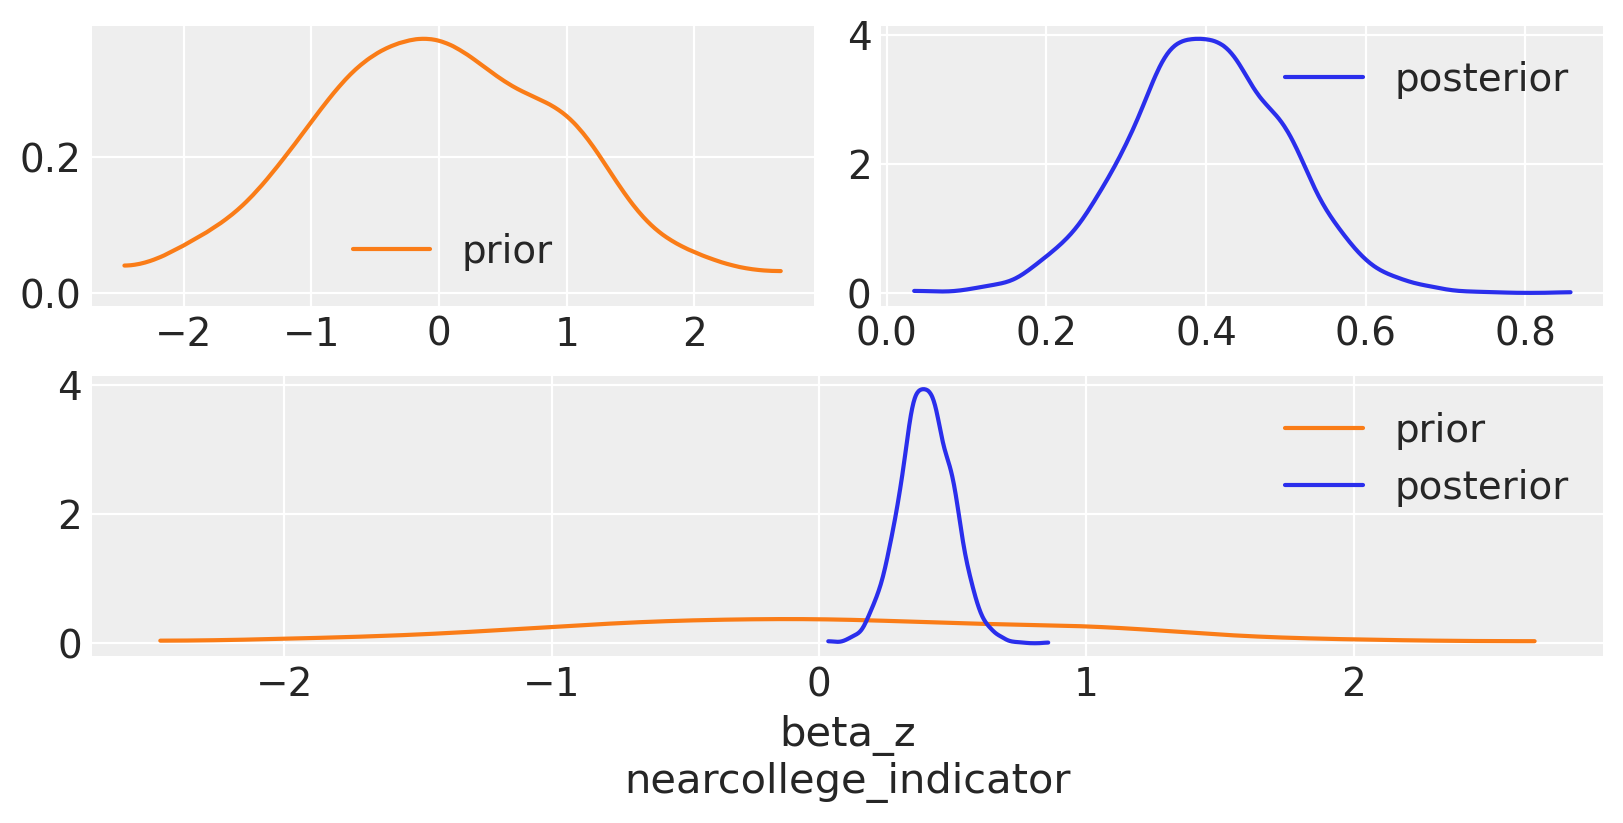

In [13]:
az.plot_dist_comparison(idata_first_stage, var_names=['beta_z'], coords={'covariates': ['nearcollege_indicator']},
                        figsize=(8, 4));

We will continue to build models including these demographic controls features, but the focus remains the instruments and their justification. 

### The Second Stage

While in the case of __relevance__ we can aim to justify our assumptions as above, but with the __exclusion restriction__ assumption we cannot directly test the claim. Remember we're arguing that the influence of our instrument $Z$ impacts our outcome $Y$ only through the treatment $T$. In our case this means that the exclusion restriction assumption would be violated if proximity to college had an impact on earnings independent of the mediating effect of schooling. This is presumably not impossible, but all counterexamples that I can think of have the feel of edge-cases that will ideally filter into irrelevance with a sufficiently large data set.  

In [14]:
az.summary(idata_second_stage['posterior']['beta_z'])[
    ["mean", "sd", "hdi_3%", "hdi_97%", "r_hat"]
]

mean     sd  hdi_3%  hdi_97%  r_hat
beta_z[Intercept]              6.217  0.018   6.184    6.251    1.0
beta_z[experience_1]          -1.953  0.385  -2.686   -1.244    1.0
beta_z[experience_2]           2.218  0.380   1.526    2.977    1.0
beta_z[ethnicity_indicator]   -0.262  0.019  -0.297   -0.226    1.0
beta_z[smsa_indicator]         0.185  0.017   0.153    0.219    1.0
beta_z[south_indicator]       -0.142  0.017  -0.172   -0.110    1.0
beta_z[nearcollege_indicator]  0.045  0.017   0.014    0.076    1.0

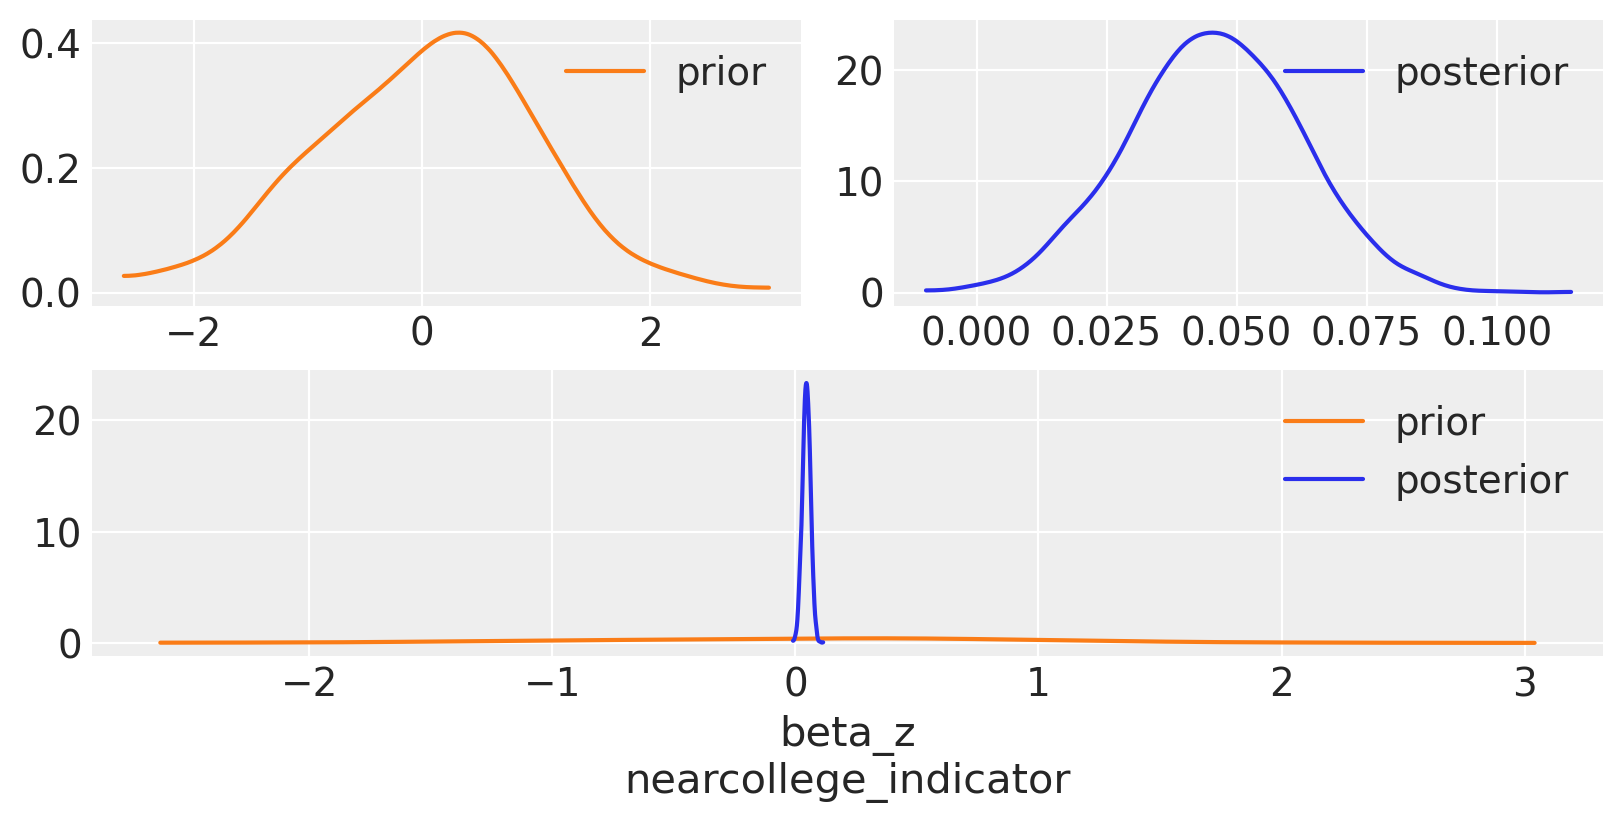

In [15]:
az.plot_dist_comparison(idata_second_stage, var_names=['beta_z'], coords={'covariates': ['nearcollege_indicator']},
                        figsize=(8, 4));

Here the second stage regression indicates a parameter estimate quite close to zero suggesting at least in the task of predicting log-wages we should see the predictive impact of proximity absorbed into the education variable.

### The Wald Estimate

These exploratory regressions give us an understanding of the dynamics at play in an instrumental variable set up, but we also get (for free) a means of calculating the LATE quantity by means of the Wald estimation routine. 

In [16]:
second = az.extract(idata_second_stage['posterior'])['beta_z'].sel(covariates='nearcollege_indicator') 
first = az.extract(idata_first_stage['posterior'])['beta_z'].sel(covariates='nearcollege_indicator')
estimate = second / first
estimate.mean()

<xarray.DataArray 'beta_z' ()> Size: 8B
array(0.12305334)
Coordinates:
    covariates  <U21 84B 'nearcollege_indicator'

Which is to say that the Wald estimate implies 0.12 in the log-wage for an additional year in education. We'll translate this to the raw outcome scale below.  

### Wald Estimate Versus Simple Controlling Regression

But now we can compare this estimate to the regression achieved with a simpler regression that just includes `education` as a control. 

In [17]:
naive_reg_model, idata_reg = make_reg_model(covariate_df.assign(education = df['education']))
az.summary(idata_reg, var_names=['beta_z'])[
    ["mean", "sd", "hdi_3%", "hdi_97%", "r_hat"]
]

Sampling: [beta_z, likelihood, sigma]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

mean     sd  hdi_3%  hdi_97%  r_hat
beta_z[Intercept]              5.348  0.047   5.259    5.433    1.0
beta_z[experience_1]          -7.210  0.441  -8.028   -6.381    1.0
beta_z[experience_2]           2.318  0.354   1.688    3.025    1.0
beta_z[ethnicity_indicator]   -0.191  0.017  -0.225   -0.159    1.0
beta_z[smsa_indicator]         0.154  0.016   0.125    0.185    1.0
beta_z[south_indicator]       -0.122  0.015  -0.150   -0.093    1.0
beta_z[nearcollege_indicator]  0.023  0.016  -0.008    0.052    1.0
beta_z[education]              0.067  0.003   0.060    0.073    1.0

Here we see how a regression which includes our instrument and our treatment sees coefficient accorded to our instrument shrink further towards 0. This is somewhat suggestive that the __exclusion restriction__ remains plausible. 

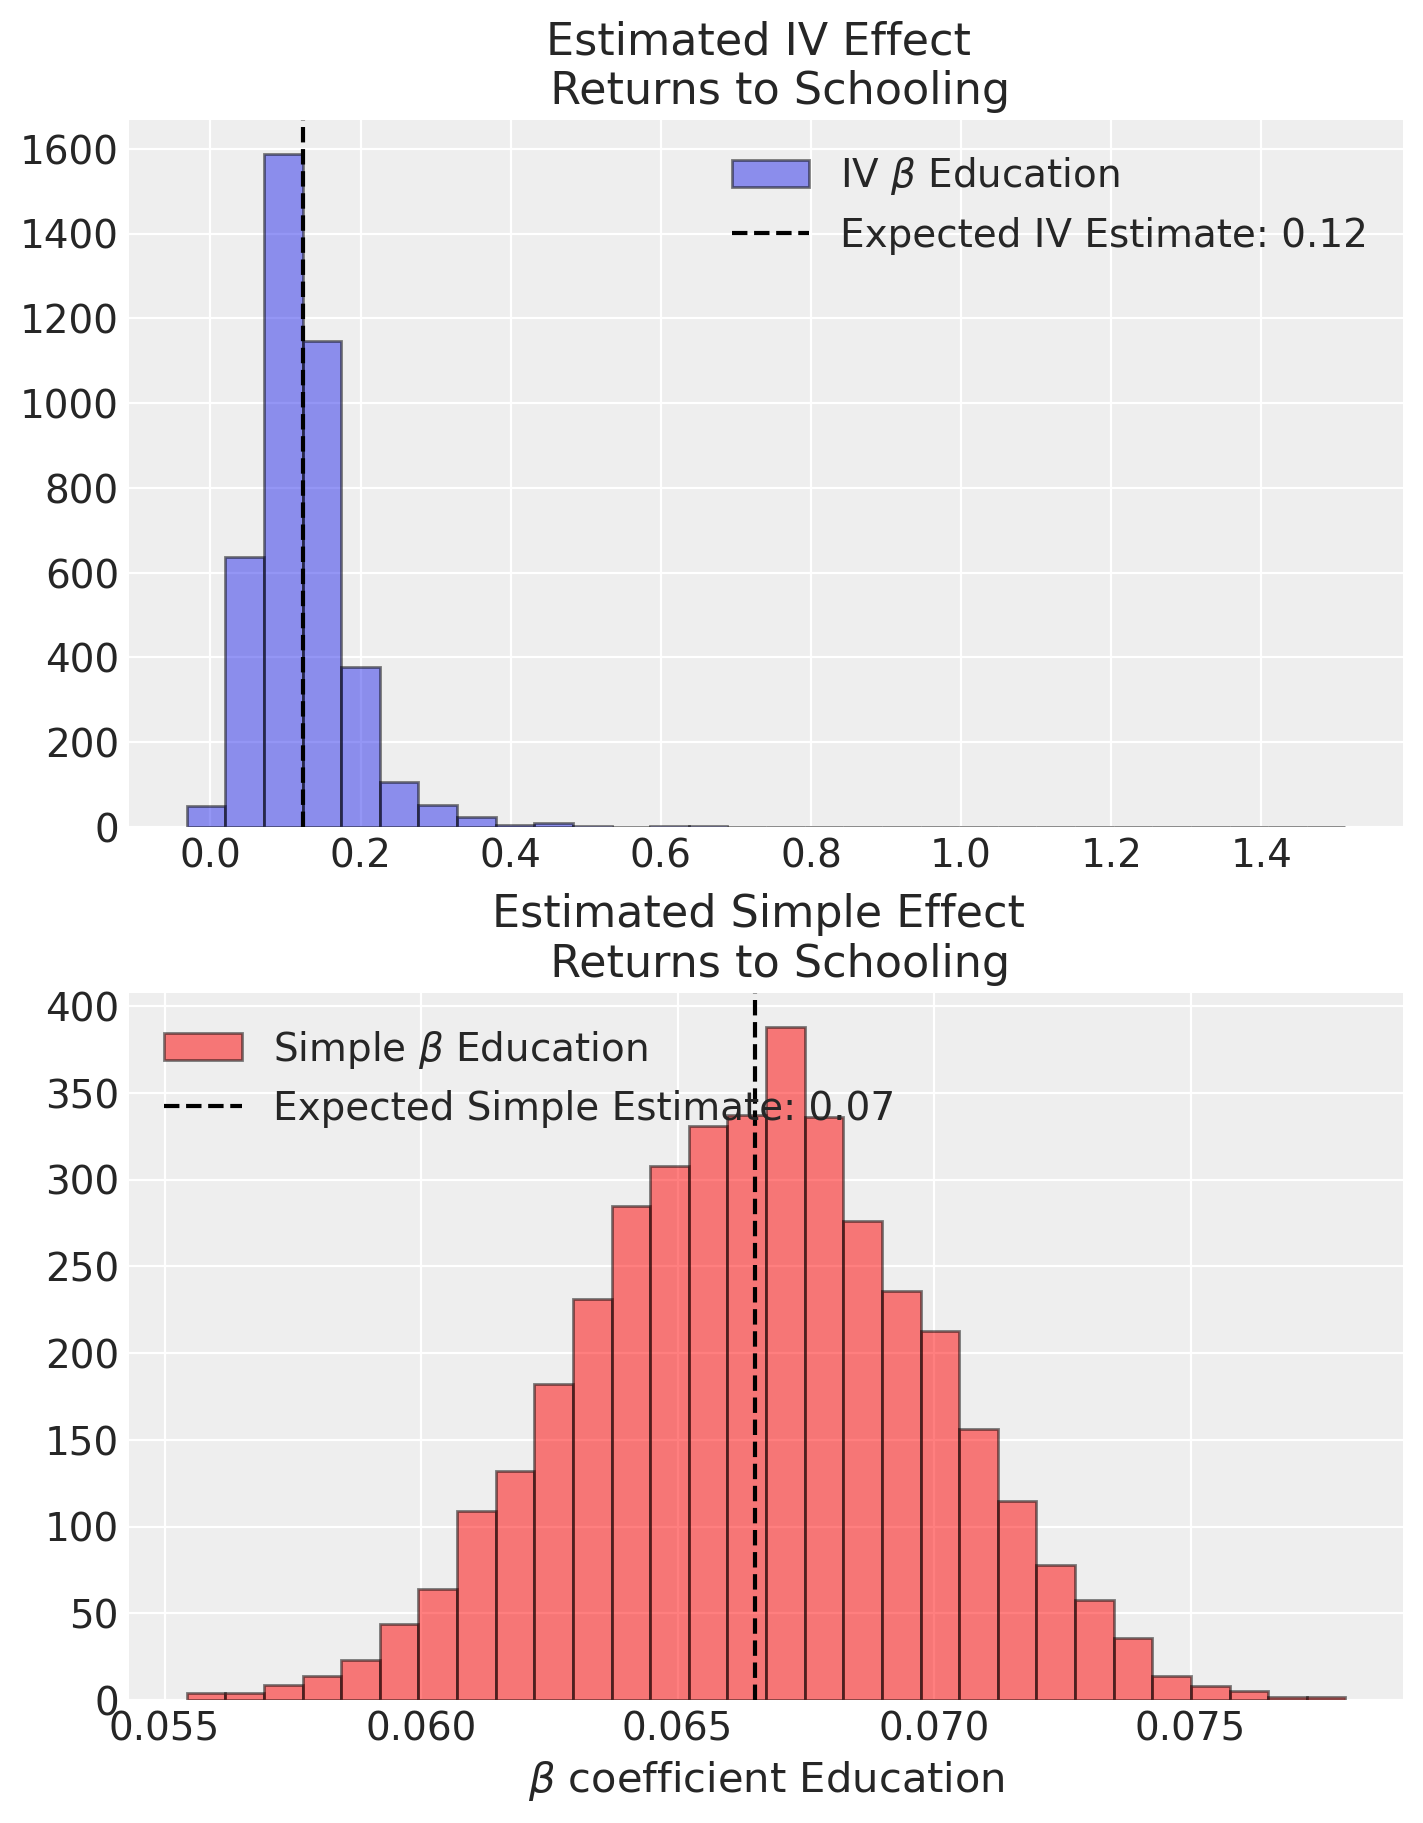

In [18]:
ols_estimate = az.extract(idata_reg['posterior'])['beta_z'].sel(covariates='education')
fig, axs = plt.subplots(2, 1, figsize=(7, 9))
axs = axs.flatten()
ax = axs[0]
ax1 = axs[1]
ax.hist(estimate, bins=30, ec='black', alpha=0.5, label=r'IV $\beta$ Education')
ax1.hist(ols_estimate, bins=30, ec='black', alpha=0.5, label=r'Simple $\beta$ Education', color='red')
ax.axvline(np.mean(estimate), linestyle='--', color='k', label=f'Expected IV Estimate: {np.round(np.mean(estimate.values), 2)}')
ax1.axvline(np.mean(ols_estimate), linestyle='--', color='k', label=f'Expected Simple Estimate: {np.round(np.mean(ols_estimate.values), 2)}')
ax1.set_xlabel(r"$\beta$ coefficient Education")

ax.legend()
ax1.legend(loc='upper left')
ax.set_title("Estimated IV Effect \n  Returns to Schooling",)
ax1.set_title("Estimated Simple Effect \n  Returns to Schooling");

Note here the marked difference in magnitude between the naive regression and the instrumental variable estimates. This contrast is in many ways at the heart of the the IV design. By proposing an IV model for our problem we're arguing that the difference in the simple regression and IV estimate is due to the influence of confounder which warps our understanding of the treatment on the outcome. The IV design is intended to remove this warping effect. Understanding the magnitude of the difference in these estimates gives some sense of the work done by the supposed confounding variable. 

### CausalPy and Multivariate Models

Now we fit the models using CausalPy's Bayesian instrumental variable regression. Here we can explicitly state the structural equations that make up our model. Importantly we ensure that the control variables included in the instrument formula are also in included in the outcome formula.

In [19]:
sample_kwargs = {
    "chains": 4,
    "cores": 4,
    "target_accept": 0.95,
    "progressbar": True, 
    "nuts_sampler": 'numpyro',  ## requires Jax and Numpyro install
    "idata_kwargs" : {'log_likelihood': True}
}
instruments_formula = "education ~ 1 + experience_1 + experience_2 + ethnicity_indicator + south_indicator + smsa_indicator + nearcollege_indicator"
formula = "log_wage ~ 1 + education  + experience_1 + experience_2 + ethnicity_indicator + south_indicator + smsa_indicator"
instruments_data = df[["education", "nearcollege_indicator", "experience_1" ,"experience_2", "ethnicity_indicator", "smsa_indicator", "south_indicator"]]
data = df[["log_wage", "education",  "experience_1" ,"experience_2", "ethnicity_indicator", "smsa_indicator", "south_indicator"]]
iv = InstrumentalVariable(
    instruments_data=instruments_data,
    data=data,
    instruments_formula=instruments_formula,
    formula=formula,
    model=InstrumentalVariableRegression(sample_kwargs=sample_kwargs),
)

az.summary(iv.idata, var_names=['beta_t', 'beta_z'])[
    ["mean", "sd", "hdi_3%", "hdi_97%", "r_hat"]
]

/Users/nathanielforde/Documents/Github/CausalPy/causalpy/data_validation.py:143: UserWarning: Warning. The treatment variable is not Binary.
                This is not necessarily a problem but it violates
                the assumption of a simple IV experiment.
                The coefficients should be interpreted appropriately.
  warnings.warn(


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

mean     sd  hdi_3%  hdi_97%  r_hat
beta_t[Intercept]              13.101  0.085  12.948   13.263   1.00
beta_t[experience_1]           89.837  0.901  88.180   91.551   1.00
beta_t[experience_2]           -0.829  0.881  -2.402    0.868   1.00
beta_t[ethnicity_indicator]    -1.007  0.090  -1.178   -0.839   1.00
beta_t[south_indicator]        -0.292  0.081  -0.453   -0.146   1.00
beta_t[smsa_indicator]          0.403  0.083   0.247    0.552   1.00
beta_t[nearcollege_indicator]   0.336  0.079   0.191    0.484   1.00
beta_z[Intercept]               4.505  0.151   4.209    4.772   1.01
beta_z[education]               0.131  0.011   0.110    0.152   1.01
beta_z[experience_1]          -14.058  0.967 -15.867  -12.294   1.01
beta_z[experience_2]            2.684  0.363   2.010    3.373   1.00
beta_z[ethnicity_indicator]    -0.132  0.022  -0.173   -0.091   1.00
beta_z[south_indicator]        -0.106  0.016  -0.138   -0.077   1.00
beta_z[smsa_indicator]          0.132  0.018   0.098    0.164   1.00

### The Coefficients of Interest

As we can see here the `beta_z[education]` coefficient records our LATE estimate and recovers substantially the same value as our 2 step Wald estimate above. Note also how the `experience_1` variable appears to be on a different magnitude than the other variables. By default the Instrumental variable class does not sample from the prior predictive or the posterior predictive distribution as in a typical `CausalPy` model. This is largely because the primary focus in IV regression is that the focus is on the `beta_z`, and `beta_t` parameters and in the focal parameter on the treatment effect. 

In [20]:
iv.idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

However it is entirely possible to sample the posterior predictive distribution in a post-model estimation step. We recommend using the Jax sampler for the posterior predictive sampling as it can be considerably faster than the base pymc sampler. 

In [21]:
iv.model.sample_predictive_distribution(ppc_sampler='jax')

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2B8478E40>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [likelihood]


Output()

Sampling: [beta_z]


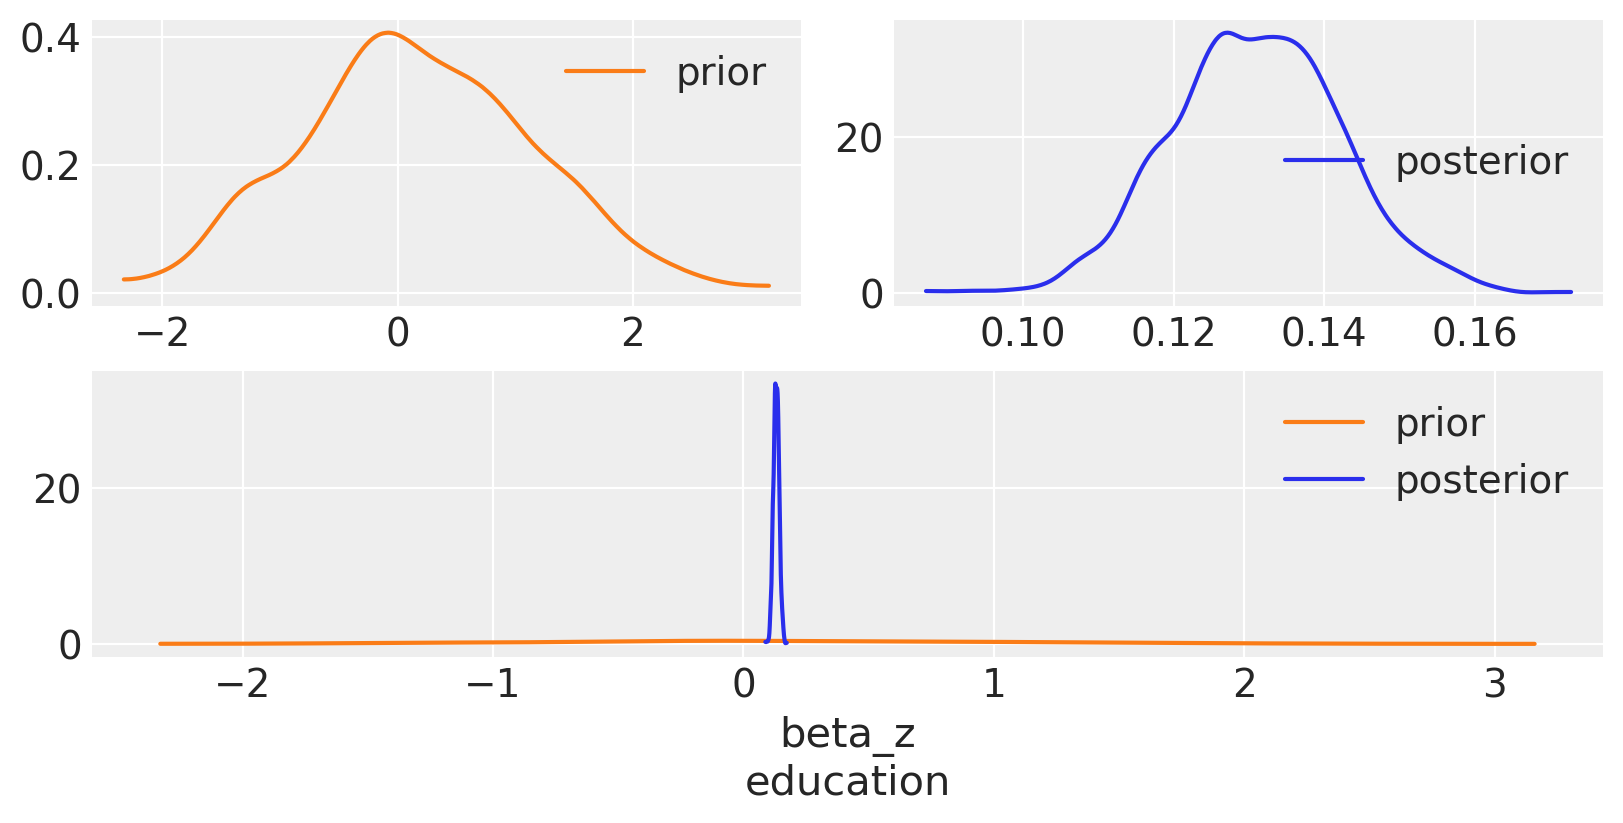

In [22]:
with iv.model:
    iv.idata.extend(pm.sample_prior_predictive(var_names=['beta_z']))
az.plot_dist_comparison(iv.idata, var_names=['beta_z'], coords={'covariates': ['education']}, figsize=(8, 4));

### Complicating the Instrument Formula

Even in this dataset we can evaluate the idea of strenghtening the instrument effect by adding additional instruments. A natural idea is to see how the instrumented values of the `education` equation vary when we add the additional `nearcollege2_indicator`. From our visual inspection of the data it seemed like there would be some value to trying to determine how proximity to both 2 and 4 year colleges drive educational attainment. 

In [23]:
sample_kwargs = {
    "chains": 4,
    "cores": 4,
    "target_accept": 0.95,
    "progressbar": True, 
    "nuts_sampler": 'numpyro', ## requires Jax and Numpyro install
    "idata_kwargs" : {'log_likelihood': True}
}
instruments_formula = """education ~  experience_1 + experience_2 + ethnicity_indicator + south_indicator + 
                                      smsa_indicator + nearcollege_indicator + nearcollege2_indicator"""

formula = "log_wage ~ 1 + education  + experience_1 + experience_2 + ethnicity_indicator + south_indicator + smsa_indicator"

instruments_data = df[["education", "nearcollege_indicator", "nearcollege2_indicator", 
                       "experience_1" ,"experience_2", "ethnicity_indicator", "smsa_indicator", "south_indicator"]]

data = df[["log_wage", "education",  "experience_1" ,"experience_2",  "ethnicity_indicator", 
           "smsa_indicator", "south_indicator"]]
iv1 = InstrumentalVariable(
    instruments_data=instruments_data,
    data=data,
    instruments_formula=instruments_formula,
    formula=formula,
    model=InstrumentalVariableRegression(sample_kwargs=sample_kwargs),
)
iv1.model.sample_predictive_distribution(ppc_sampler='jax')

az.summary(iv1.idata, var_names=['beta_t', 'beta_z'])[
    ["mean", "sd", "hdi_3%", "hdi_97%", "r_hat"]
]

/Users/nathanielforde/Documents/Github/CausalPy/causalpy/data_validation.py:143: UserWarning: Warning. The treatment variable is not Binary.
                This is not necessarily a problem but it violates
                the assumption of a simple IV experiment.
                The coefficients should be interpreted appropriately.
  warnings.warn(


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2BA367A00>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [likelihood]


Output()

mean     sd  hdi_3%  hdi_97%  r_hat
beta_t[Intercept]               13.058  0.089  12.889   13.224    1.0
beta_t[experience_1]            89.925  0.887  88.223   91.550    1.0
beta_t[experience_2]            -0.816  0.905  -2.450    0.974    1.0
beta_t[ethnicity_indicator]     -1.014  0.088  -1.183   -0.857    1.0
beta_t[south_indicator]         -0.278  0.077  -0.435   -0.145    1.0
beta_t[smsa_indicator]           0.386  0.083   0.240    0.551    1.0
beta_t[nearcollege_indicator]    0.311  0.077   0.171    0.456    1.0
beta_t[nearcollege2_indicator]   0.153  0.067   0.028    0.279    1.0
beta_z[Intercept]                4.124  0.155   3.828    4.410    1.0
beta_z[education]                0.160  0.012   0.139    0.183    1.0
beta_z[experience_1]           -16.631  0.969 -18.556  -14.928    1.0
beta_z[experience_2]             2.715  0.349   2.079    3.382    1.0
beta_z[ethnicity_indicator]     -0.103  0.023  -0.146   -0.061    1.0
beta_z[south_indicator]         -0.095  0.017  -0.128   -0.065    1.0
beta_z[smsa_indicator]           0.118  0.018   0.084    0.153    1.0

Here we see how the inclusion of the extra instrument has pushed the LATE estimate up from .13 to .16. This is at least intuitively plausible and perhaps lends strength to the overall idea that proximity is a good instrument.

### Credible Inference and the Credibility Revolution.

How far can we push the idea? How vulnerable is our inference to model mis-specification? Can we stress test the parameter estimates by trying strong priors? The IV methodology is palpably about argument - credible argument for the proposed mechanism. With this in mind, one benefit of the Bayesian modelling approach to IV is that we can express and stretch the credibility of the mechanism in the model design. We can stress-test the credibility of inferences by trying to impose contestable beliefs as priors on the model and see the degree to which the inferences are anchored by our prior specifications and how much the data pulls us away from more incredible postulates. 

Here we'll refit our original IV model, but we'll scale the `experience_1` variable to have a mean of 0. This allows place priors of roughly the same scale on all variables. 

In [24]:
sample_kwargs = {
    "chains": 4,
    "cores": 4,
    "target_accept": 0.95,
    "progressbar": True, 
    "nuts_sampler": 'numpyro',  ## requires Jax and Numpyro install
    "idata_kwargs" : {'log_likelihood': True}
}
instruments_formula = """education ~ experience_1 + experience_2 + ethnicity_indicator + south_indicator + 
                                      smsa_indicator + nearcollege_indicator
                                      """
formula = "log_wage ~ 1 + education + experience_1 + experience_2 + ethnicity_indicator + south_indicator + smsa_indicator"
instruments_data = df[["education", "nearcollege_indicator",
                       "experience_1" ,"experience_2", "ethnicity_indicator", "smsa_indicator", "south_indicator"]]
data = df[["log_wage", "education",  "experience_1" ,"experience_2", "ethnicity_indicator", "smsa_indicator", "south_indicator"]]

scaler = StandardScaler()
data['experience_1'] = scaler.fit_transform(data[['experience_1']])
instruments_data['experience_1'] = scaler.fit_transform(instruments_data[['experience_1']])
data[['log_wage', 'education', 'experience_1', 'experience_2']]

/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_4265/3108691870.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['experience_1'] = scaler.fit_transform(data[['experience_1']])
/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_4265/3108691870.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  instruments_data['experience_1'] = scaler.fit_transform(instruments_data[['experience_1']])


log_wage  education  experience_1  experience_2
0     6.306275          7     -1.725159     -0.016329
1     6.175867         12     -0.034739      0.014776
2     6.580639         12     -1.725159     -0.016329
3     5.521461         11     -0.276228      0.015422
4     6.591674         12     -1.725159     -0.016329
...        ...        ...           ...           ...
3005  5.814131         12      0.448238      0.008397
3006  6.175867         13     -1.483670     -0.006796
3007  6.214608         12      0.689727      0.002662
3008  6.569481         12     -1.000693      0.007180
3009  6.263398         13      0.448238      0.008397

[3010 rows x 4 columns]

We will then modify our prior for the LATE estimate upward to .2. Trying to pull the inference up for the sake of argument. 

In [25]:
modified = iv.ols_beta_second_params
modified[1] = .20
modified[2] = 0
modified

[4.486489832009674,
 0.2,
 0,
 2.6929616114117123,
 -0.13080191375573674,
 -0.10490054155737207,
 0.13132367504470194]

In [26]:
modified_first = iv.ols_beta_first_params
modified_first[1] = 0
modified_first

[13.098074632594448,
 0,
 -0.8633797925737376,
 -1.0061382678610173,
 -0.29146401700569985,
 0.40387687667134015,
 0.33732078008876376]

Additionally we'll constrain the possible correlations we believe acceptable by upping the `eta` parameter and upping the standard deviations of the multivariate normal. 

In [27]:
iv2 = InstrumentalVariable(
    instruments_data=instruments_data,
    data=data,
    instruments_formula=instruments_formula,
    formula=formula,
    model=InstrumentalVariableRegression(sample_kwargs=sample_kwargs),
    priors = {"mus": [modified_first, modified], "sigmas": [1, 1],
                      "eta": 10, "lkj_sd": 2}
)

az.summary(iv2.idata, var_names=['beta_t', 'beta_z'])[
    ["mean", "sd", "hdi_3%", "hdi_97%", "r_hat"]
]

/Users/nathanielforde/Documents/Github/CausalPy/causalpy/data_validation.py:143: UserWarning: Warning. The treatment variable is not Binary.
                This is not necessarily a problem but it violates
                the assumption of a simple IV experiment.
                The coefficients should be interpreted appropriately.
  warnings.warn(


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

mean     sd  hdi_3%  hdi_97%  r_hat
beta_t[Intercept]              13.097  0.086  12.935   13.256   1.00
beta_t[experience_1]            1.635  0.037   1.569    1.706   1.00
beta_t[experience_2]           -0.868  0.879  -2.463    0.808   1.00
beta_t[ethnicity_indicator]    -1.007  0.089  -1.173   -0.839   1.00
beta_t[south_indicator]        -0.292  0.078  -0.437   -0.147   1.00
beta_t[smsa_indicator]          0.404  0.084   0.248    0.567   1.00
beta_t[nearcollege_indicator]   0.339  0.080   0.192    0.490   1.00
beta_z[Intercept]               4.850  0.388   4.069    5.543   1.01
beta_z[education]               0.105  0.029   0.051    0.162   1.01
beta_z[experience_1]           -0.213  0.048  -0.305   -0.125   1.01
beta_z[experience_2]            2.673  0.352   1.997    3.313   1.00
beta_z[ethnicity_indicator]    -0.158  0.034  -0.224   -0.096   1.00
beta_z[south_indicator]        -0.114  0.018  -0.146   -0.078   1.00
beta_z[smsa_indicator]          0.145  0.022   0.105    0.186   1.00

Sampling: [beta_z]


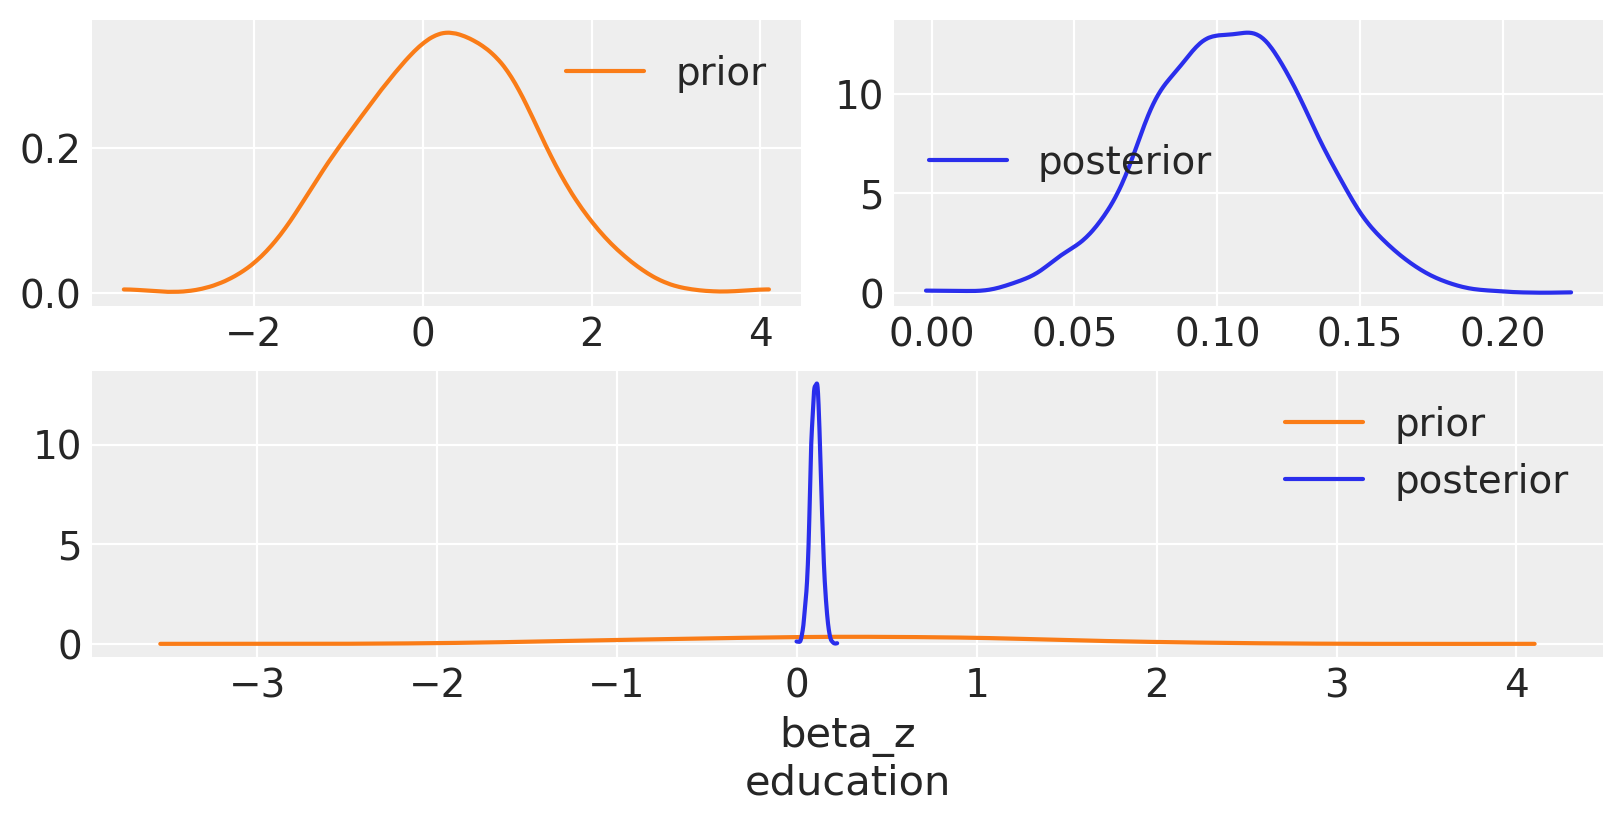

In [28]:
with iv2.model:
    iv2.idata.extend(pm.sample_prior_predictive(var_names=['beta_z']))
az.plot_dist_comparison(iv2.idata, var_names=['beta_z'], coords={'covariates': ['education']}, figsize=(8, 4));

### Comparing Model Inferences

Just to make the emerging picture clearer we pull out and plot the credible intervals for the parameter estimates implied by each model. Here we can see the different implications induced by each model configuration. Note how all the IV models pull the credible intervals away from the simpler OLS type model estimate. 

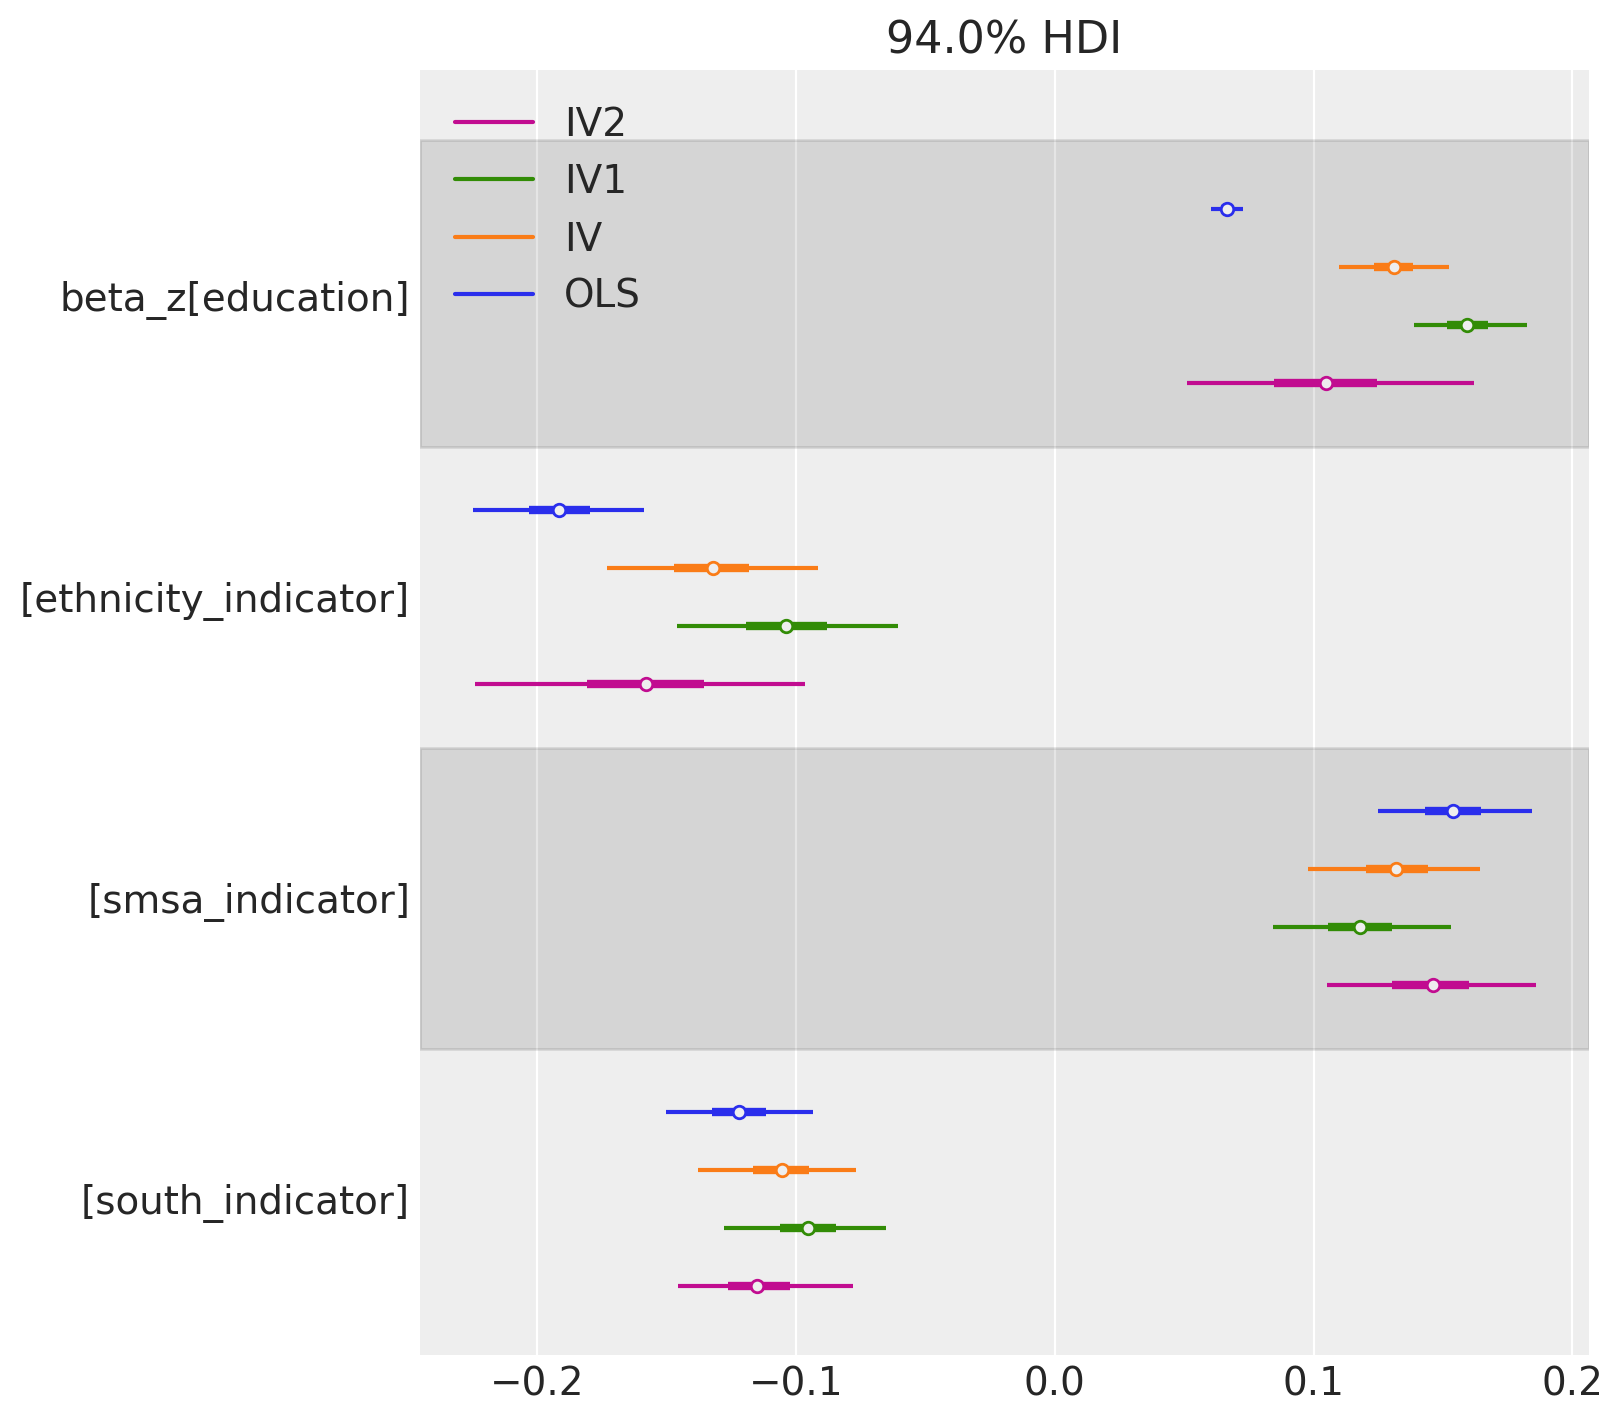

In [29]:
az.plot_forest([idata_reg, iv.idata, iv1.idata, iv2.idata], var_names=['beta_z'], 
               coords={'covariates': ['education', 'ethnicity_indicator', 
                                      'smsa_indicator', 'south_indicator']}, combined=True, 
               model_names=['OLS', 'IV', 'IV1', 'IV2'], figsize=(8, 7));

The increased uncertainty in our final model is being driven by uncertainty in the correlation parameters. But despite our attempt to pull the LATE estimate upwards the process of Bayesian updating pulled the HDI of our credibility interval into a perfectly reasonable range overlapping considerably with our first IV fit. 

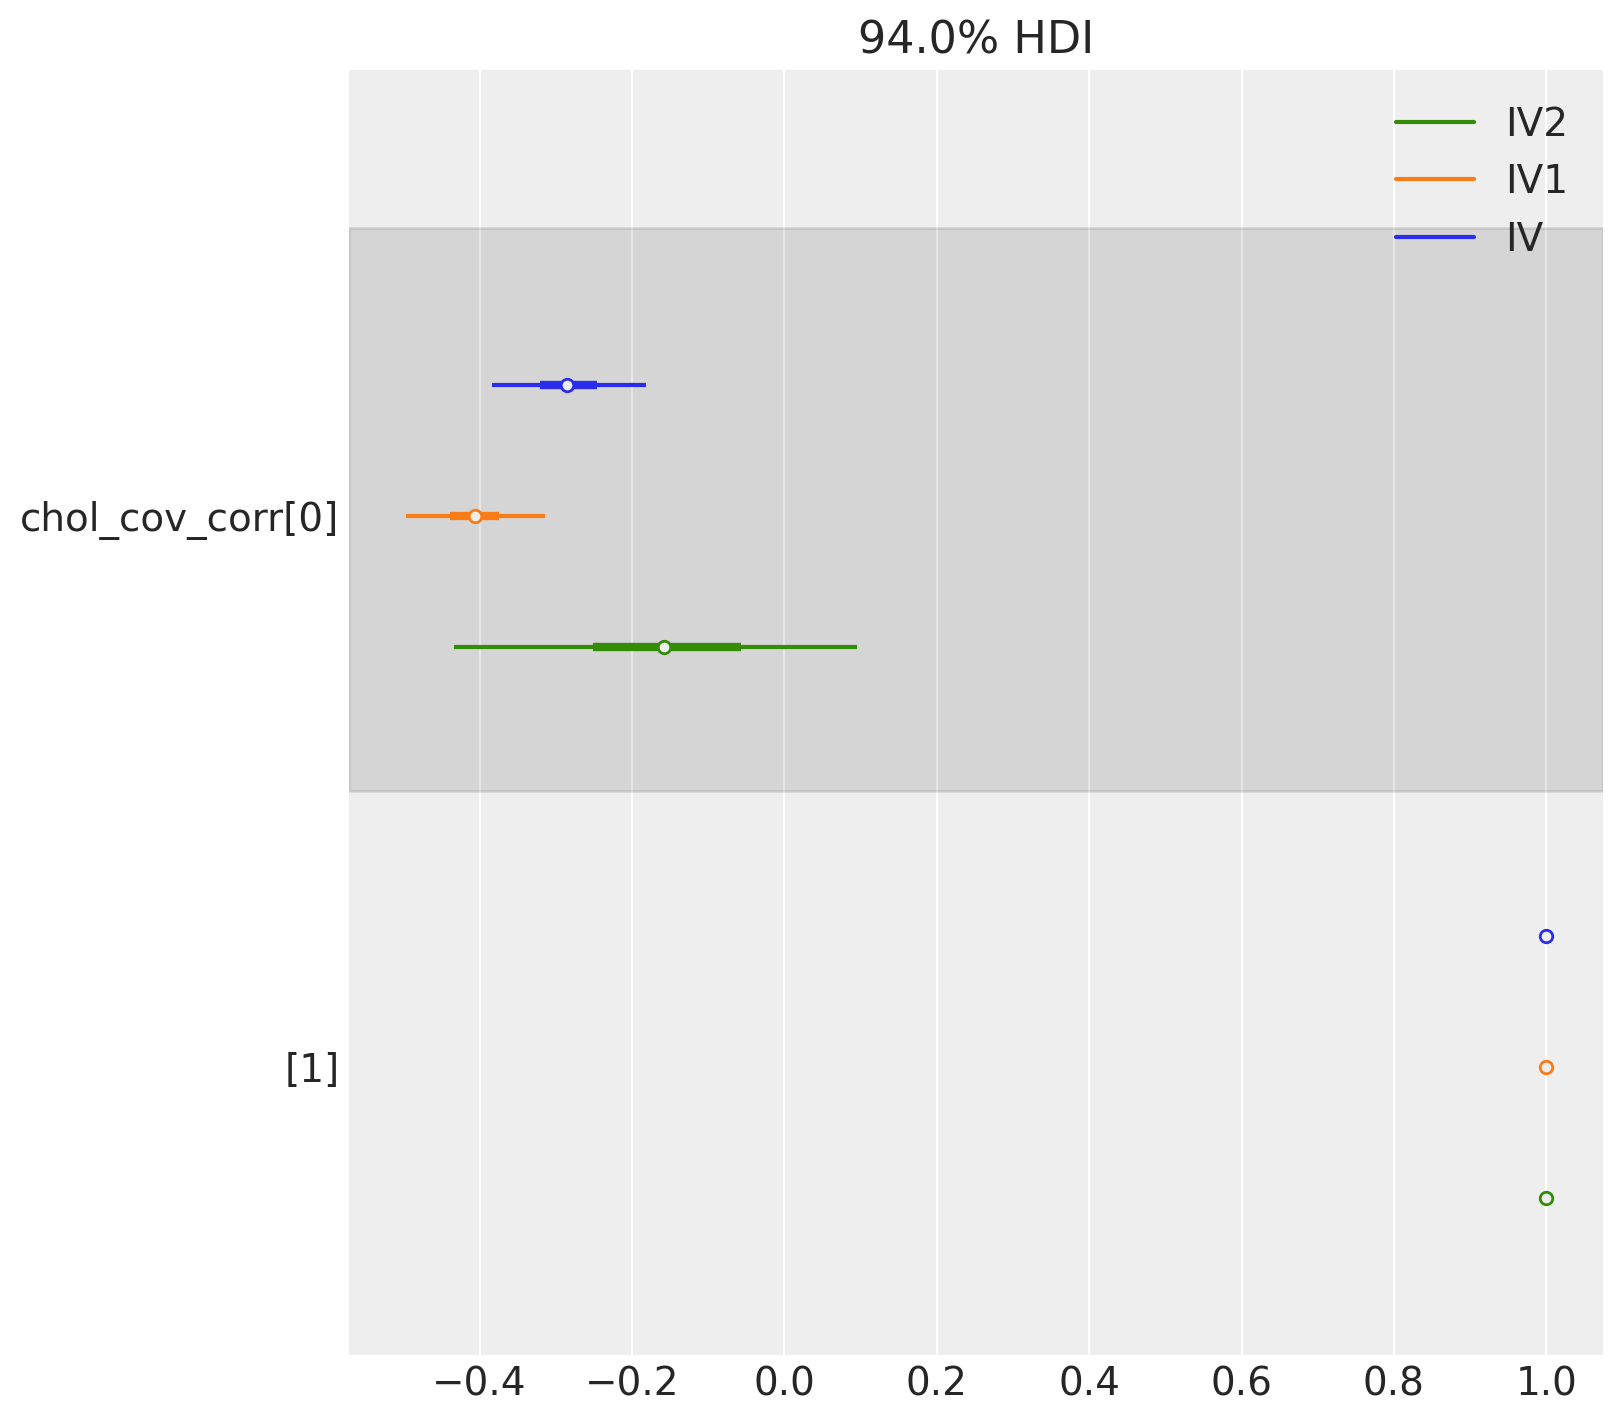

In [30]:
az.plot_forest([iv.idata, iv1.idata, iv2.idata], var_names=['chol_cov_corr'], 
               coords={'chol_cov_corr_dim_1': [1]}, combined=True, 
               model_names=['IV', 'IV1', 'IV2'], figsize=(8, 7));

The uncertainty in the correlation implied in the last model kind of undermines this model specification. If our argument about the instrument is to be compelling we would expect __relevance__ to hold. A model specification which degrades the relevance by means of reduced correlation is perhaps too extreme. The point here is not to argue about the parameter settings, just to show that multiple models need to be considered and some sensetivity testing is always warranted when justifying an IV design.  

### Model Evaluation in Outcome Space

One final way to compare the credibility of each model is to translate the implications into the outcome space and think through what the differences in parameter estimates really means. Below we visualise the implications for log-wages due to education effects under each model. 

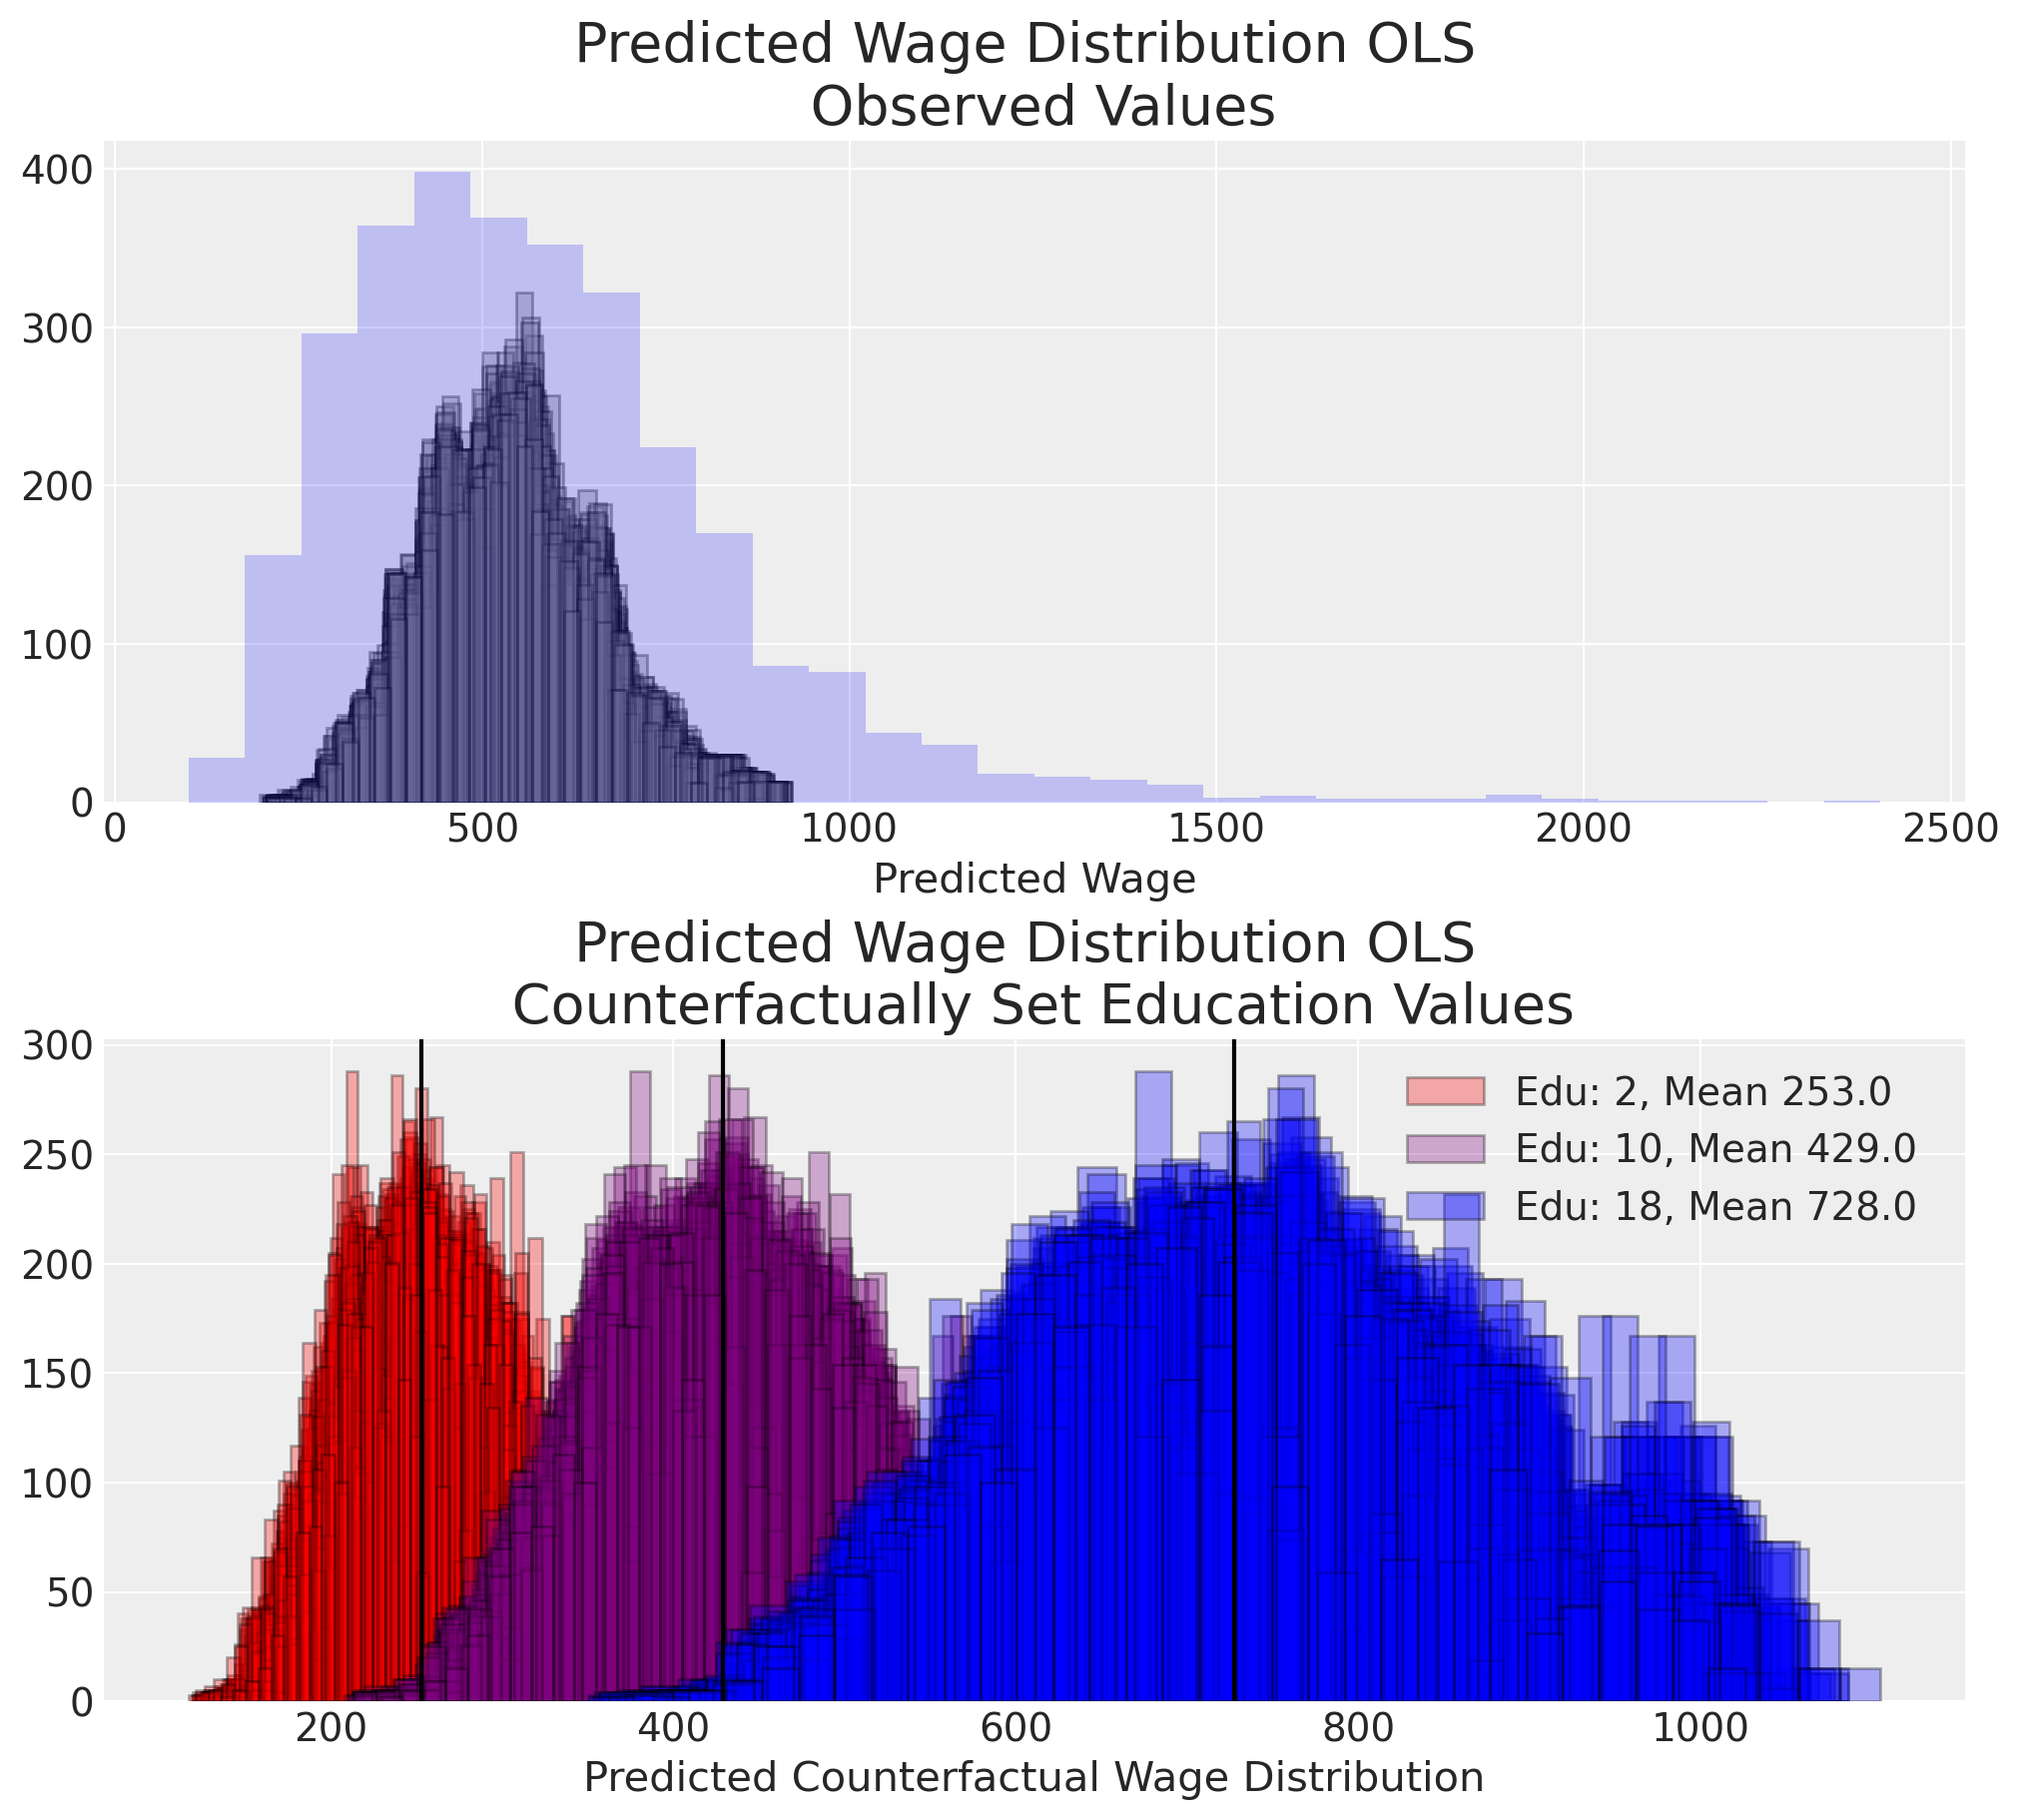

In [31]:
def make_compare_plot(iv, y, model_name, columns):
    data = df.copy()
    data['Intercept'] = 1
    covariate_df = data[covariates]
    params = az.extract(iv['posterior']['beta_z'])['beta_z']

    fig, axs = plt.subplots(2, 1, figsize=(10, 9))
    axs = axs.flatten()
    for i in range(100):
        axs[0].hist(np.exp(np.dot(covariate_df, params[:, i].T)), alpha=0.3, bins=30, ec='black', color='grey')
    axs[0].set_title(f"Predicted Wage Distribution {model_name} \n Observed Values", fontsize=20)
    axs[0].hist(np.exp(y), bins=30, alpha=0.2, color='blue')
    axs[0].set_xlabel("Predicted Wage")
    for c, ed in zip(['red', 'purple', 'blue'],[2, 10, 18]):
        temp = covariate_df.copy()
        temp['education'] = ed
        means = []
        for i in range(100):
            dist = np.exp(np.dot(temp, params[:, i].T))
            means.append(np.mean(dist))
            if i == 99:
                axs[1].hist(dist, alpha=0.3, bins=30, ec='black', color=c, label=f'Edu: {ed}, Mean {np.round(np.mean(means))} ')
            else:
                axs[1].hist(dist, alpha=0.3, bins=30, ec='black', color=c)
        axs[1].axvline(np.mean(means), color='k')
    axs[1].set_title(f"Predicted Wage Distribution {model_name} \n Counterfactually Set Education Values", fontsize=20)
    axs[1].set_xlabel("Predicted Counterfactual Wage Distribution")
    axs[1].legend()


covariates = list(idata_reg['posterior']['beta_z']['covariates'].values)
make_compare_plot(idata_reg, data['log_wage'], 'OLS', covariates)

Here we see the simple regression implications under the counterfactual setting where each individual in the data set has their educational attainment set to 2, 10, 18 years respectively. The differences in expectations is then plotted. Next we show the same for the candidate IV model.

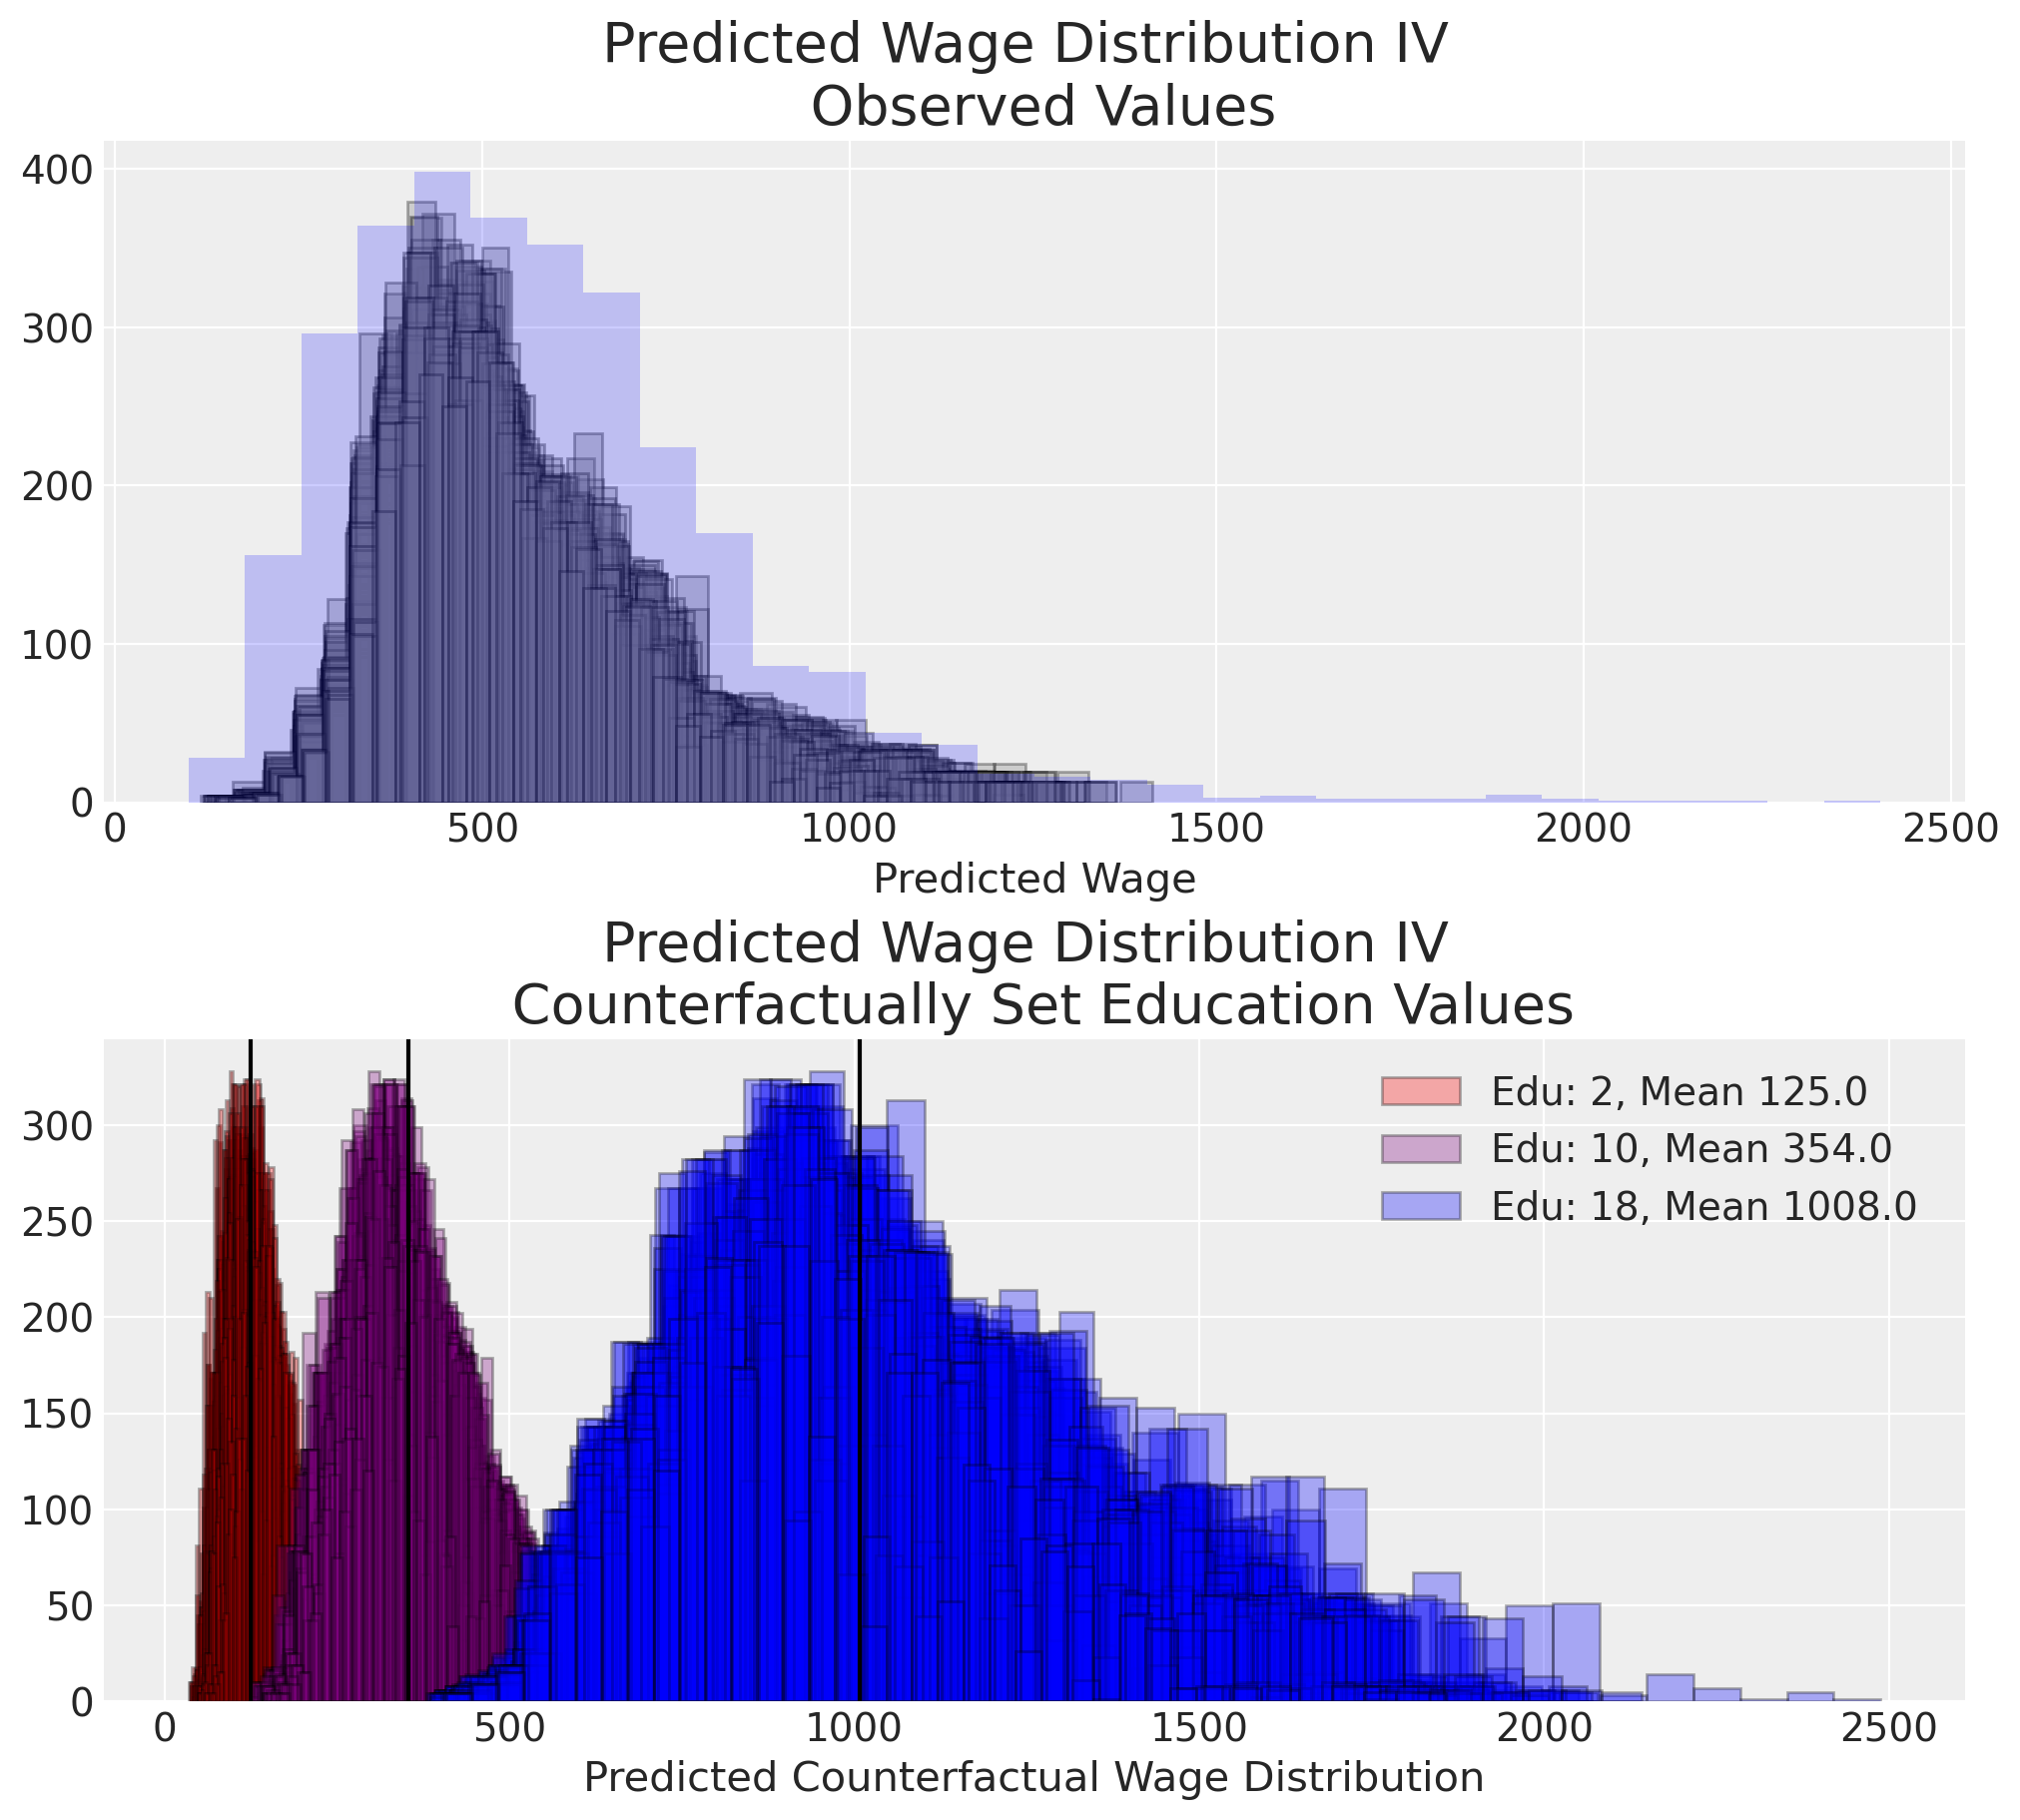

In [32]:
covariates = list(iv.idata['posterior']['beta_z']['covariates'].values)
make_compare_plot(iv.idata, data['log_wage'], 'IV', covariates)

Here we see a stark difference in the shape of the implied distributions are far better recovery of the observed data in the posterior predictive plot. 

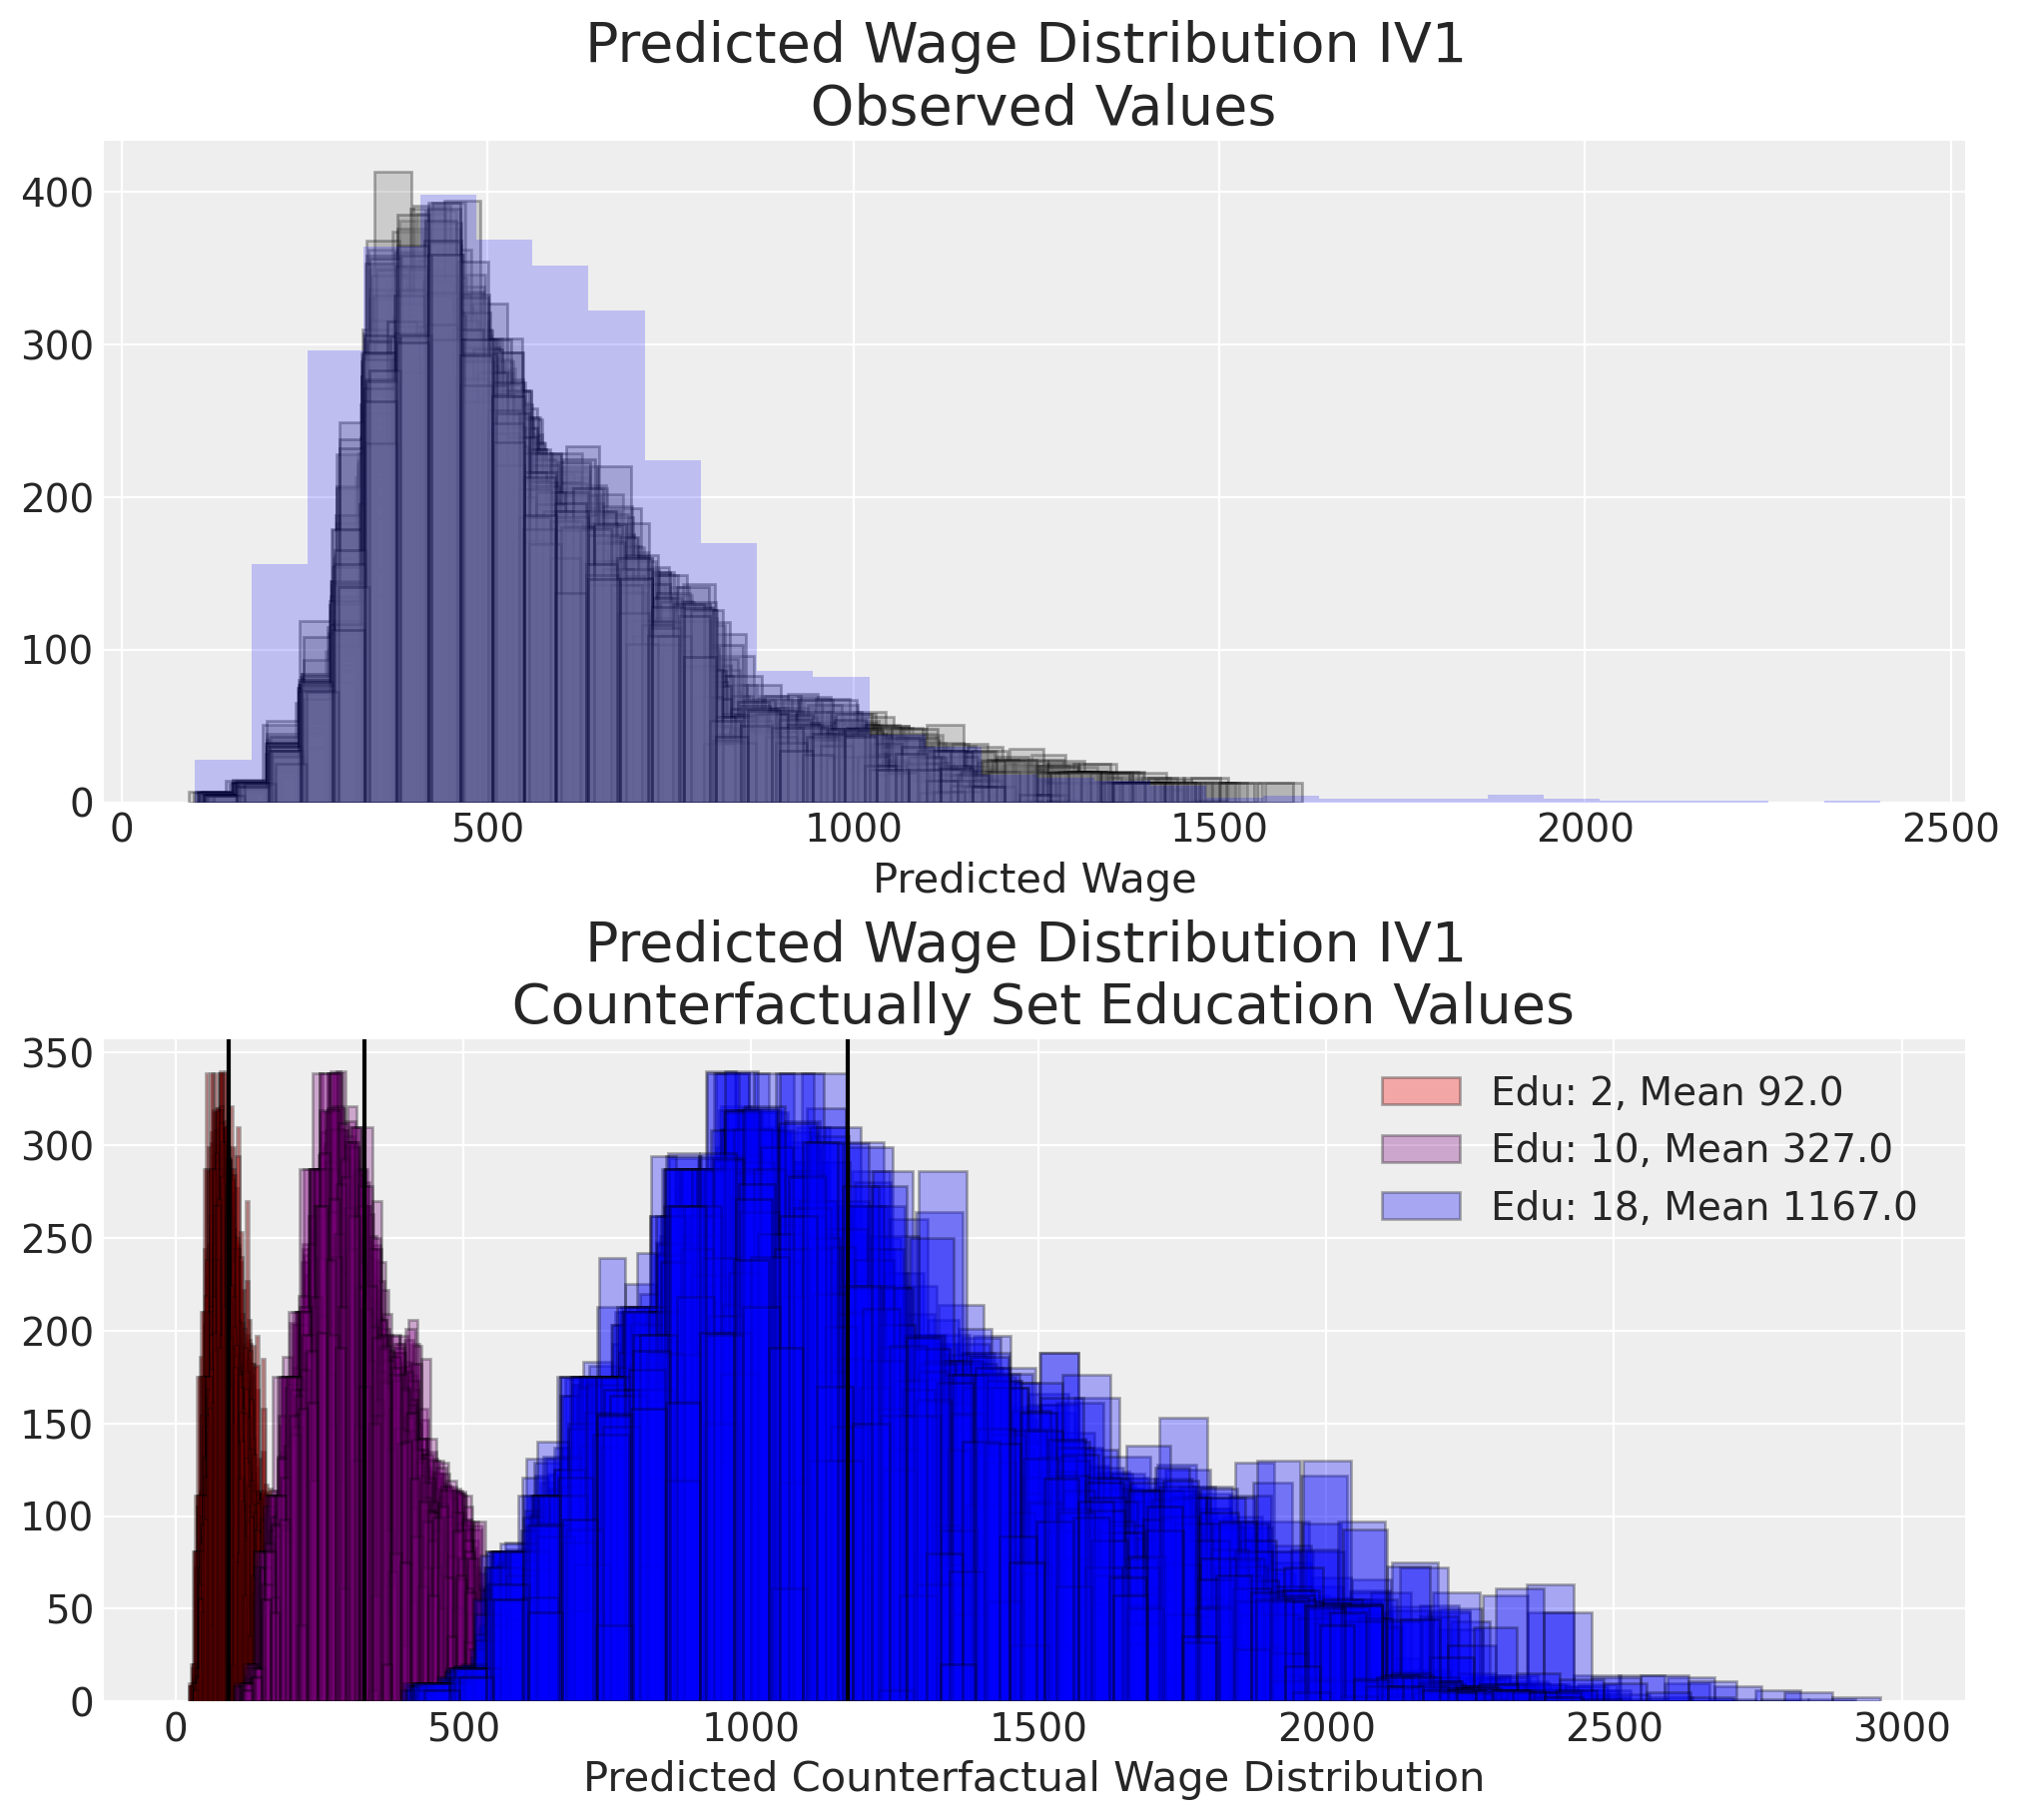

In [33]:
covariates = list(iv1.idata['posterior']['beta_z']['covariates'].values)
make_compare_plot(iv1.idata, data['log_wage'], 'IV1', covariates)

Our second IV model shows a similar story to the first with improved coverage of the long-tail features of the log-wage distribution.

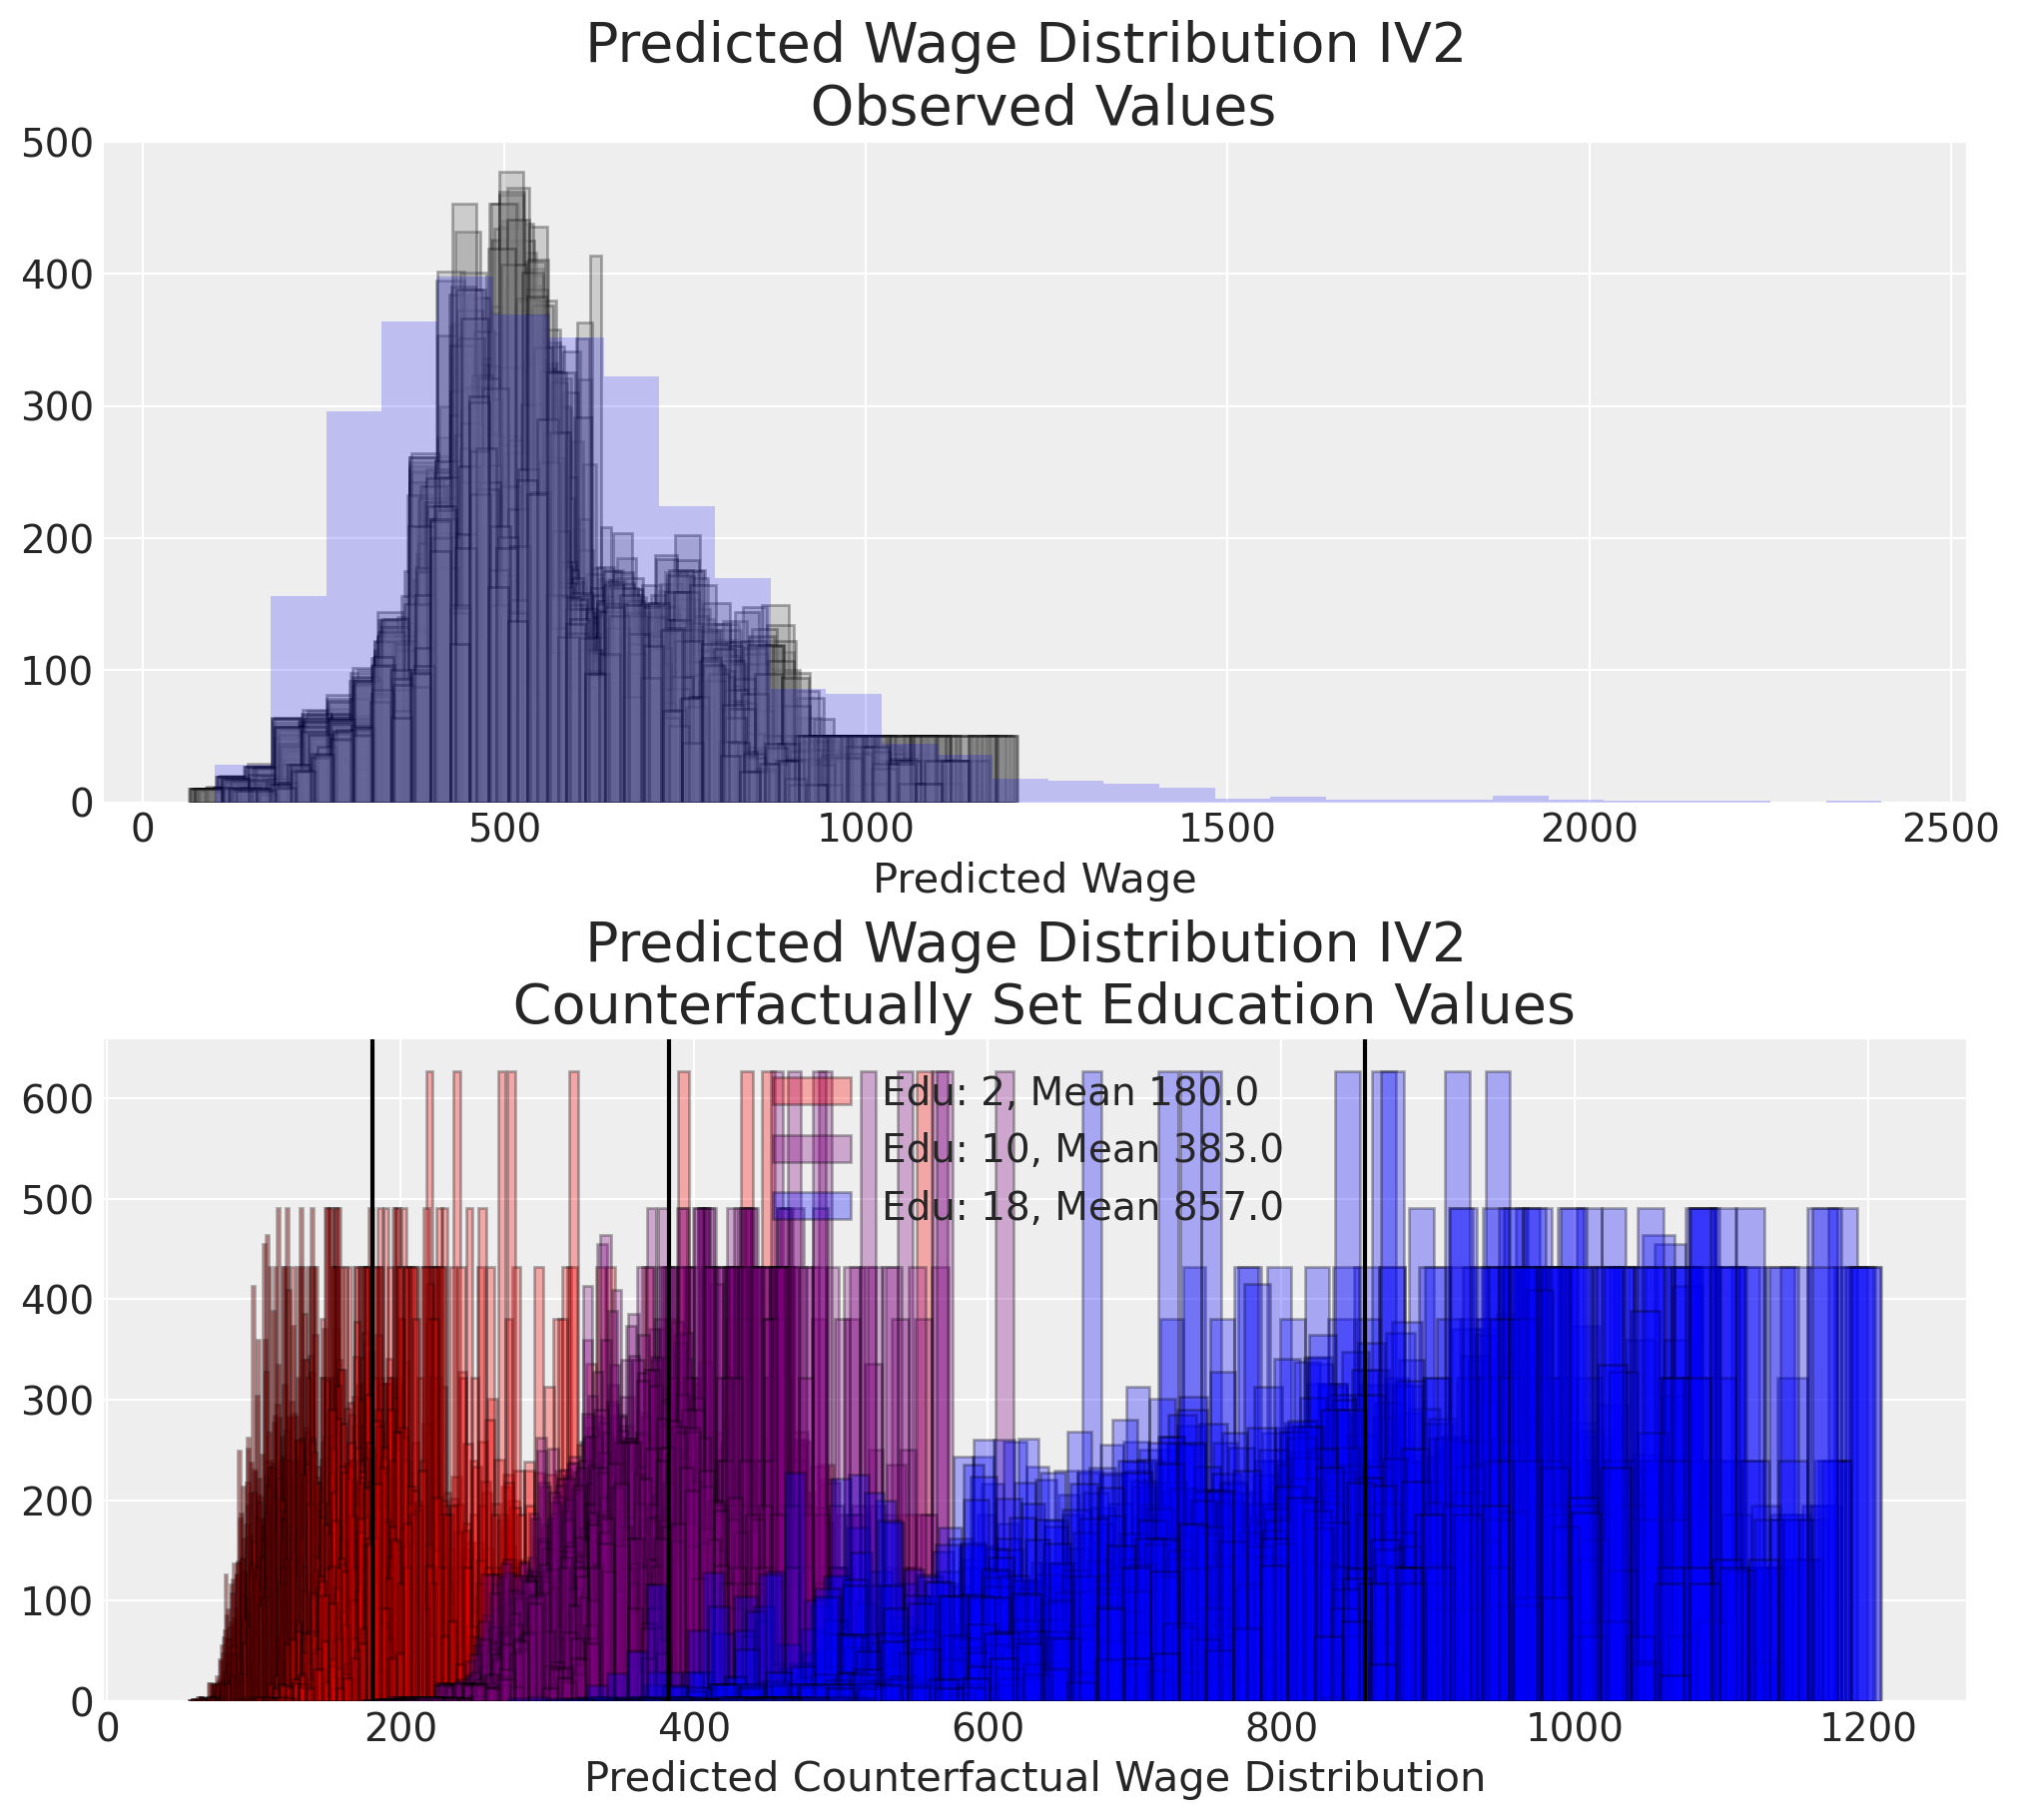

In [34]:
covariates = list(iv2.idata['posterior']['beta_z']['covariates'].values)
make_compare_plot(iv2.idata, data['log_wage'], 'IV2', covariates)

Our final model shows a somewhat chaotic realisations of the predicted and counterfactual distributions suggesting it is not in fact a great model for our data. We can also formalise this model comparison in their predictive power.

In [35]:
compare_df = az.compare({'IV': iv.idata, 'IV1': iv1.idata, 'IV2': iv2.idata})
compare_df[['rank',	'elpd_loo',	'p_loo','elpd_diff','weight']]

rank     elpd_loo      p_loo  elpd_diff    weight
IV1     0 -7586.795250  15.274378   0.000000  0.812495
IV      1 -7588.551123  14.512149   1.755874  0.187505
IV2     2 -7589.594014  15.284955   2.798765  0.000000

The final analysis should be driven by the plausibility of the implications on the raw `wage` scale. But it's useful to know how and whether a particular model fit compares in predictive power against other reasonable candidate models. 

### Conclusion

In this demonstration we've seen an example of IV regression justification conducted in a Bayesian setting. Crucially we've tried to convey the centrality of argument and model justification that is required in this mode of causal inference. These requirements are true whether you're fitting the IV model with a frequentist model or a Bayesian model, but the process of justification and model-credibility-comparison is neatly phrased in the routine of Bayesian model workflow. 